In [97]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [98]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Transformer Class

In [99]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, d_model=128, n_heads=4, n_layers=1, d_ff=512, max_seq_len=3):
        super(Transformer, self).__init__()
        self.token_embedding = nn.Embedding(num_tokens, d_model)
        # Create a learned positional embedding matrix of shape (1, max_seq_len, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, d_model))
        
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff) for _ in range(n_layers)
        ])
        
        self.fc_out = nn.Linear(d_model, num_tokens, bias=False)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len) containing token indices.
        Returns:
            logits: Output tensor of shape (batch_size, seq_len, num_tokens)
        """
        batch_size, seq_len = x.size()
        token_emb = self.token_embedding(x)
        # Slice the positional embeddings to match the sequence length
        pos_emb = self.pos_embedding[:, :seq_len, :]
        x = token_emb + pos_emb
        
        for layer in self.layers:
            x = layer(x)
            
        logits = self.fc_out(x)
        return logits

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        """
        A single transformer block without layer normalization.
        """
        super(TransformerBlock, self).__init__()
        # Multi-head self-attention (using batch_first=True for convenience)
        self.attention = nn.MultiheadAttention(d_model, n_heads, batch_first=True, bias = False)
        # Feed-forward network components with ReLU activation.
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # Self-attention: Query, Key, and Value are all the same.
        attn_output, _ = self.attention(x, x, x)
        # Add residual connection.
        x = x + attn_output
        
        # Feed-forward network with ReLU.
        ff_output = self.fc2(F.relu(self.fc1(x)))
        # Add residual connection.
        x = x + ff_output
        return x

### Dataset

In [100]:
def generate_modular_addition_data(p: int):
    """
    Generate training data for modular addition given a prime number p.

    Assumptions:
    - Token IDs 0 to p-1 correspond to the numbers 0, 1, ..., p-1.
    - The token ID for the "=" symbol is p.
    
    Returns:
    - inputs: A tensor of shape (p*p, 3), where each row is (n_x, n_y, n_=).
    - labels: A tensor of shape (p*p,) with the result (x+y) mod p.
    """
    inputs = []
    labels = []
    equal_token = p  # The token ID for the "=" symbol.

    for x in range(p):
        for y in range(p):
            # Create the triplet (number x, number y, equal symbol token)
            inputs.append([x, y, equal_token])
            # Compute the modular addition label.
            labels.append((x + y) % p)
    
    # Convert lists to torch tensors.
    inputs_tensor = torch.tensor(inputs, dtype=torch.long)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    return inputs_tensor, labels_tensor

### Weight Analysis

In [101]:
def analyze_embedding_matrix(embedding_matrix):
    """
    Performs DFT on the rows of the given embedding_matrix and plots
    the norm (L2) of the cosine (real) and sine (imaginary) components
    for each frequency.

    Args:
        embedding_matrix (torch.Tensor): A tensor of shape (batch_size, seq_len),
            where each row is a signal of length seq_len.
    """
    # Turn off gradient tracking for this analysis.
    with torch.no_grad():
        # Compute the FFT along the signal length dimension (dim=1).
        fft_result = torch.fft.fft(embedding_matrix, dim=1)
        
        # Separate the real (cosine) and imaginary (sine) parts.
        real_part = fft_result.real  # cosine coefficients
        imag_part = fft_result.imag  # sine coefficients

        # For each frequency k, compute the L2 norm across rows.
        # This gives one norm per frequency for the cosine and sine parts.
        norm_cos = torch.sqrt(torch.sum(real_part**2, dim=0)).cpu().numpy()  # shape: (seq_len,)
        norm_sin = torch.sqrt(torch.sum(imag_part**2, dim=0)).cpu().numpy()  # shape: (seq_len,)

    # Create a frequency axis.
    seq_len = embedding_matrix.shape[1]
    freqs = np.arange(seq_len)

    # Plot the Fourier component norms.
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, norm_cos, label='Cosine Norm (Real Part)')
    plt.plot(freqs, norm_sin, label='Sine Norm (Imaginary Part)')
    plt.xlabel('Frequency k')
    plt.ylabel('L2 Norm')
    plt.title('DFT Analysis of Embedding Matrix')
    plt.legend()
    plt.show()



def plot_embedding_projections(embedding_matrix, stage_label=''):
    """
    Computes a PCA (2 components) projection for a token embedding matrix,
    applies standard scaling, then plots the projection.
    
    The first element is labeled as "1", the second as "2", ..., and the last as "=".
    
    Args:
        embedding_matrix (torch.Tensor): A tensor of shape (num_tokens, embedding_dim),
            e.g., for 114 tokens.
        stage_label (str): A label to identify the training stage (e.g., "Epoch 0", "Epoch 500").
    """
    # Convert the embedding to a NumPy array.
    emb_np = embedding_matrix.detach().cpu().numpy()
    
    # Standardize each dimension to zero mean, unit variance.
    scaled_emb = StandardScaler().fit_transform(emb_np)
    
    # Compute PCA (2 components) on the scaled data.
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(scaled_emb)
    
    num_tokens = emb_np.shape[0]
    
    # Create labels: for indices 0 to num_tokens-2, use numbers (starting at 1); for the last token, use "=".
    labels = [str(i+1) for i in range(num_tokens)]
    labels[-1] = "="
    
    # Create a figure.
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the points as faint dots so you can see them behind the labels.
    ax.scatter(emb_pca[:, 0], emb_pca[:, 1], alpha=0.2, color="blue")
    
    # Add text labels at each point.
    for i, (x, y) in enumerate(emb_pca):
        ax.text(x, y, labels[i], fontsize=10, ha='center', va='center')
    
    ax.set_title(f"PCA Projection {stage_label}")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    
    # Optionally, make axes have equal scale so circles look like circles, etc.
    # ax.set_aspect('equal', 'box')
    
    plt.show()

### Training

In [102]:
def train_model(model, p, proportion, num_epochs):
    """
    Trains a transformer model for modular addition.

    Args:
        model: The model to train.
        p (int): The prime number used in modular addition.
        proportion (float): Proportion of the dataset to use for training (between 0 and 1).
        num_epochs (int): Number of training epochs.
    
    Returns:
        model: The trained transformer model.
    """
    # Generate the full dataset.
    inputs, labels = generate_modular_addition_data(p)
    total_examples = inputs.shape[0]
    
    # Split the dataset into training and test sets.
    train_size = int(proportion * total_examples)
    test_size = total_examples - train_size
    indices = torch.randperm(total_examples)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    train_inputs = inputs[train_indices]
    train_labels = labels[train_indices]
    test_inputs = inputs[test_indices]
    test_labels = labels[test_indices]

    # Define the optimizer and loss function.
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1)
    criterion = nn.CrossEntropyLoss()

    # Lists for storing metrics.
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Training loop.
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Forward pass on the training set.
        logits = model(train_inputs)  # logits shape: (train_size, seq_len, num_tokens)
        logits_answer = logits[:, -1, :]  # Use the last token's output for prediction.
        loss = criterion(logits_answer, train_labels)
        loss.backward()
        optimizer.step()

        # Compute training metrics.
        train_loss = loss.item()
        _, train_preds = torch.max(logits_answer, dim=1)
        train_accuracy = (train_preds == train_labels).float().mean().item()

        # Evaluate on the test set.
        model.eval()
        with torch.no_grad():
            test_logits = model(test_inputs)
            test_logits_answer = test_logits[:, -1, :]
            test_loss = criterion(test_logits_answer, test_labels).item()
            _, test_preds = torch.max(test_logits_answer, dim=1)
            test_accuracy = (test_preds == test_labels).float().mean().item()
        model.train()

        # Record metrics.
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print metrics every 100 epochs.
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")
            
        if (epoch + 1) % 5000 == 0:
            plot_embedding_projections(model.token_embedding.weight, stage_label=f"Epoch {epoch+1}")

    analyze_embedding_matrix(model.token_embedding.weight)

    # Plot the evolution of loss and accuracy.
    epochs = range(1, num_epochs + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Loss evolution.
    axs[0].plot(epochs, train_losses, label="Train Loss")
    axs[0].plot(epochs, test_losses, label="Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss Evolution")
    axs[0].legend()

    # Accuracy evolution.
    axs[1].plot(epochs, train_accuracies, label="Train Accuracy")
    axs[1].plot(epochs, test_accuracies, label="Test Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy Evolution")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return model

In [103]:
def train_small_model(model, p, proportion, num_epochs):
    """
    Trains a transformer model for modular addition.

    Args:
        model: The model to train.
        p (int): The prime number used in modular addition.
        proportion (float): Proportion of the dataset to use for training (between 0 and 1).
        num_epochs (int): Number of training epochs.
    
    Returns:
        model: The trained transformer model.
    """
    # Generate the full dataset.
    inputs, labels = generate_modular_addition_data(p)
    total_examples = inputs.shape[0]
    
    # Split the dataset into training and test sets.
    train_size = int(proportion * total_examples)
    test_size = total_examples - train_size
    indices = torch.randperm(total_examples)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    train_inputs = inputs[train_indices]
    train_labels = labels[train_indices]
    test_inputs = inputs[test_indices]
    test_labels = labels[test_indices]

    # Define the optimizer and loss function.
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1)
    criterion = nn.CrossEntropyLoss()

    # Lists for storing metrics.
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Training loop.
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Forward pass on the training set.
        logits = model(train_inputs)  # logits shape: (train_size, seq_len, num_tokens)
        logits_answer = logits[:, -1, :]  # Use the last token's output for prediction.
        loss = criterion(logits_answer, train_labels)
        loss.backward()
        optimizer.step()

        # Compute training metrics.
        train_loss = loss.item()
        _, train_preds = torch.max(logits_answer, dim=1)
        train_accuracy = (train_preds == train_labels).float().mean().item()

        # Evaluate on the test set.
        model.eval()
        with torch.no_grad():
            test_logits = model(test_inputs)
            test_logits_answer = test_logits[:, -1, :]
            test_loss = criterion(test_logits_answer, test_labels).item()
            _, test_preds = torch.max(test_logits_answer, dim=1)
            test_accuracy = (test_preds == test_labels).float().mean().item()
        model.train()

        # Record metrics.
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print metrics every 100 epochs.
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")
            
        if (epoch + 1) % 5000 == 0:
            # Convert the embeddings to a NumPy array.
            emb_np = model.token_embedding.weight.detach().cpu().numpy()
            num_tokens = emb_np.shape[0]

            # Create labels: tokens 0 to num_tokens-2 as "1", "2", ..., and the last token as "=".
            labels = [str(i+1) for i in range(num_tokens)]
            labels[-1] = "="

            plt.figure(figsize=(6, 6))
            # Plot each point and annotate it.
            for i, (x, y) in enumerate(emb_np):
                plt.scatter(x, y, color='blue')
                plt.text(x, y, labels[i], fontsize=12, ha='center', va='center')
            
            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.title(f"2D Token Embeddings {epoch +1}")
            plt.grid(True)
            plt.show() 

    analyze_embedding_matrix(model.token_embedding.weight)             

    # Plot the evolution of loss and accuracy.
    epochs = range(1, num_epochs + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Loss evolution.
    axs[0].plot(epochs, train_losses, label="Train Loss")
    axs[0].plot(epochs, test_losses, label="Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss Evolution")
    axs[0].legend()

    # Accuracy evolution.
    axs[1].plot(epochs, train_accuracies, label="Train Accuracy")
    axs[1].plot(epochs, test_accuracies, label="Test Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy Evolution")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return model

In [11]:
p = 113
model = Transformer(p + 1, d_model=128, n_heads=4, n_layers=1, d_ff=512, max_seq_len=3)
trained_model = train_model(model, p, proportion=0.3, num_epochs=20000)

Epoch 100/20000, Train Loss: 2.8799, Test Loss: 7.4479, Train Acc: 0.2634, Test Acc: 0.0015
Epoch 200/20000, Train Loss: 0.1702, Test Loss: 17.8600, Train Acc: 0.9914, Test Acc: 0.0023
Epoch 300/20000, Train Loss: 0.0448, Test Loss: 18.7627, Train Acc: 1.0000, Test Acc: 0.0023
Epoch 400/20000, Train Loss: 0.0347, Test Loss: 17.7827, Train Acc: 1.0000, Test Acc: 0.0021
Epoch 500/20000, Train Loss: 0.0293, Test Loss: 17.1673, Train Acc: 1.0000, Test Acc: 0.0026
Epoch 600/20000, Train Loss: 0.0253, Test Loss: 16.8030, Train Acc: 1.0000, Test Acc: 0.0025
Epoch 700/20000, Train Loss: 0.0224, Test Loss: 16.5786, Train Acc: 1.0000, Test Acc: 0.0019
Epoch 800/20000, Train Loss: 0.0199, Test Loss: 16.4490, Train Acc: 1.0000, Test Acc: 0.0021
Epoch 900/20000, Train Loss: 0.0178, Test Loss: 16.3511, Train Acc: 1.0000, Test Acc: 0.0021
Epoch 1000/20000, Train Loss: 0.0160, Test Loss: 16.3194, Train Acc: 1.0000, Test Acc: 0.0023
Epoch 1100/20000, Train Loss: 0.0146, Test Loss: 16.3184, Train Acc: 1

KeyboardInterrupt: 

Epoch 500/20000, Train Loss: 0.0025, Test Loss: 17.6945, Train Acc: 1.0000, Test Acc: 0.0038
Epoch 1000/20000, Train Loss: 0.0162, Test Loss: 13.3971, Train Acc: 1.0000, Test Acc: 0.0113
Epoch 1500/20000, Train Loss: 0.0399, Test Loss: 9.9619, Train Acc: 1.0000, Test Acc: 0.0415
Epoch 2000/20000, Train Loss: 0.0262, Test Loss: 8.8451, Train Acc: 1.0000, Test Acc: 0.0792
Epoch 2500/20000, Train Loss: 0.0141, Test Loss: 9.1168, Train Acc: 1.0000, Test Acc: 0.1170
Epoch 3000/20000, Train Loss: 0.0077, Test Loss: 9.4106, Train Acc: 1.0000, Test Acc: 0.1585
Epoch 3500/20000, Train Loss: 0.0051, Test Loss: 9.3758, Train Acc: 1.0000, Test Acc: 0.2038
Epoch 4000/20000, Train Loss: 0.0035, Test Loss: 9.0017, Train Acc: 1.0000, Test Acc: 0.2377
Epoch 4500/20000, Train Loss: 0.0025, Test Loss: 8.7129, Train Acc: 1.0000, Test Acc: 0.2943
Epoch 5000/20000, Train Loss: 0.0019, Test Loss: 8.6761, Train Acc: 1.0000, Test Acc: 0.3245


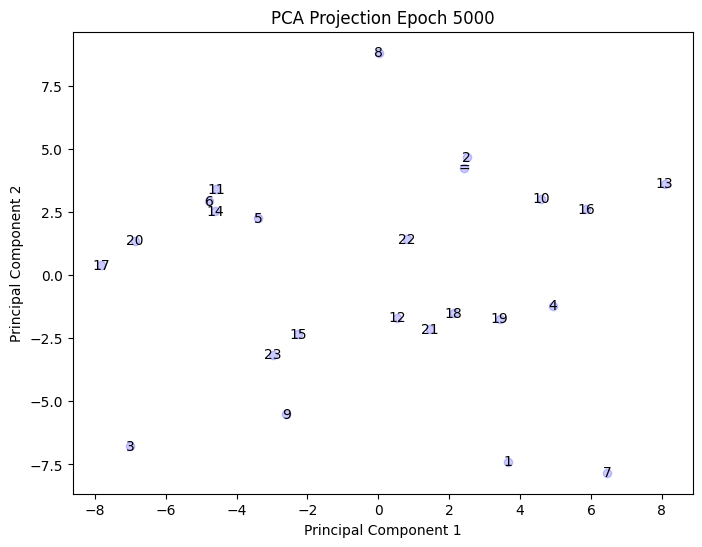

Epoch 5500/20000, Train Loss: 0.0013, Test Loss: 8.6246, Train Acc: 1.0000, Test Acc: 0.3245
Epoch 6000/20000, Train Loss: 0.0010, Test Loss: 8.6030, Train Acc: 1.0000, Test Acc: 0.3283
Epoch 6500/20000, Train Loss: 0.0092, Test Loss: 5.0096, Train Acc: 1.0000, Test Acc: 0.4226
Epoch 7000/20000, Train Loss: 0.0036, Test Loss: 5.3332, Train Acc: 1.0000, Test Acc: 0.4377
Epoch 7500/20000, Train Loss: 0.0023, Test Loss: 5.3045, Train Acc: 1.0000, Test Acc: 0.5094
Epoch 8000/20000, Train Loss: 0.0016, Test Loss: 5.3886, Train Acc: 1.0000, Test Acc: 0.5170
Epoch 8500/20000, Train Loss: 0.0011, Test Loss: 5.2028, Train Acc: 1.0000, Test Acc: 0.5472
Epoch 9000/20000, Train Loss: 0.0008, Test Loss: 5.1066, Train Acc: 1.0000, Test Acc: 0.5698
Epoch 9500/20000, Train Loss: 0.0006, Test Loss: 4.9795, Train Acc: 1.0000, Test Acc: 0.5736
Epoch 10000/20000, Train Loss: 0.0004, Test Loss: 4.9768, Train Acc: 1.0000, Test Acc: 0.5849


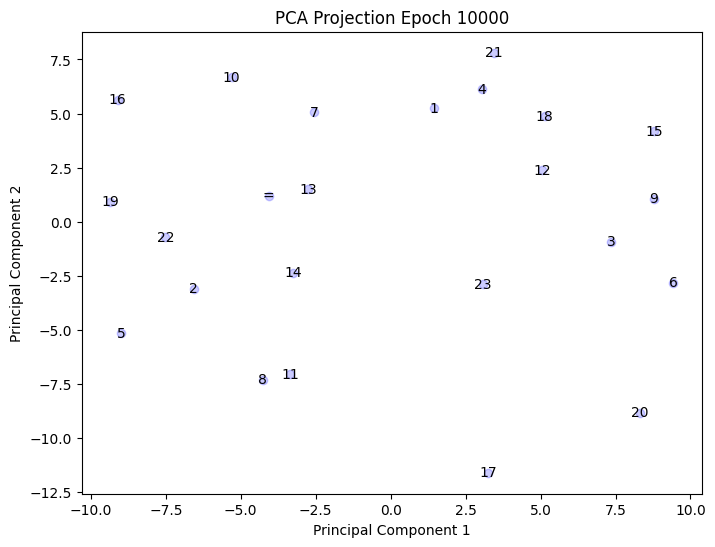

Epoch 10500/20000, Train Loss: 0.0003, Test Loss: 4.9563, Train Acc: 1.0000, Test Acc: 0.5962
Epoch 11000/20000, Train Loss: 0.0002, Test Loss: 5.0565, Train Acc: 1.0000, Test Acc: 0.5962
Epoch 11500/20000, Train Loss: 0.0002, Test Loss: 5.0754, Train Acc: 1.0000, Test Acc: 0.5887
Epoch 12000/20000, Train Loss: 0.0001, Test Loss: 4.9888, Train Acc: 1.0000, Test Acc: 0.5925
Epoch 12500/20000, Train Loss: 0.0001, Test Loss: 4.8948, Train Acc: 1.0000, Test Acc: 0.6264
Epoch 13000/20000, Train Loss: 0.0001, Test Loss: 4.8388, Train Acc: 1.0000, Test Acc: 0.6377
Epoch 13500/20000, Train Loss: 0.0001, Test Loss: 4.6665, Train Acc: 1.0000, Test Acc: 0.6528
Epoch 14000/20000, Train Loss: 0.0000, Test Loss: 4.3238, Train Acc: 1.0000, Test Acc: 0.6642
Epoch 14500/20000, Train Loss: 0.0000, Test Loss: 4.1775, Train Acc: 1.0000, Test Acc: 0.6642
Epoch 15000/20000, Train Loss: 0.0000, Test Loss: 4.1567, Train Acc: 1.0000, Test Acc: 0.6717


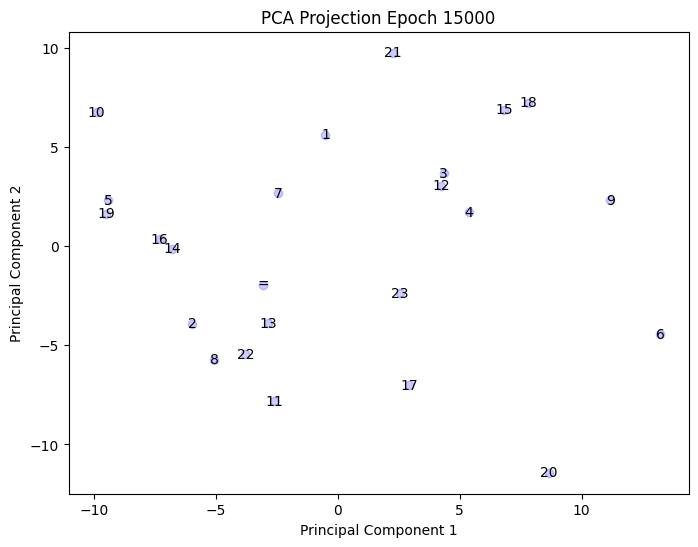

Epoch 15500/20000, Train Loss: 0.0000, Test Loss: 4.1513, Train Acc: 1.0000, Test Acc: 0.7019
Epoch 16000/20000, Train Loss: 0.0093, Test Loss: 2.1062, Train Acc: 1.0000, Test Acc: 0.6830
Epoch 16500/20000, Train Loss: 0.0024, Test Loss: 2.0925, Train Acc: 1.0000, Test Acc: 0.7019
Epoch 17000/20000, Train Loss: 0.0016, Test Loss: 1.2864, Train Acc: 1.0000, Test Acc: 0.7887
Epoch 17500/20000, Train Loss: 0.0009, Test Loss: 1.0809, Train Acc: 1.0000, Test Acc: 0.8151
Epoch 18000/20000, Train Loss: 2.9207, Test Loss: 3.1939, Train Acc: 0.1098, Test Acc: 0.0453
Epoch 18500/20000, Train Loss: 0.0268, Test Loss: 0.7443, Train Acc: 1.0000, Test Acc: 0.8566
Epoch 19000/20000, Train Loss: 0.0467, Test Loss: 0.3510, Train Acc: 1.0000, Test Acc: 0.8943
Epoch 19500/20000, Train Loss: 1.6300, Test Loss: 1.8790, Train Acc: 0.4205, Test Acc: 0.2604
Epoch 20000/20000, Train Loss: 0.0224, Test Loss: 0.0409, Train Acc: 1.0000, Test Acc: 1.0000


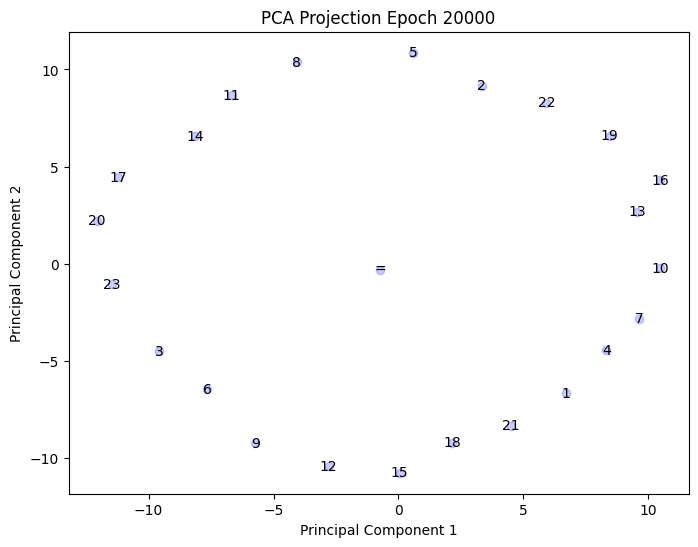

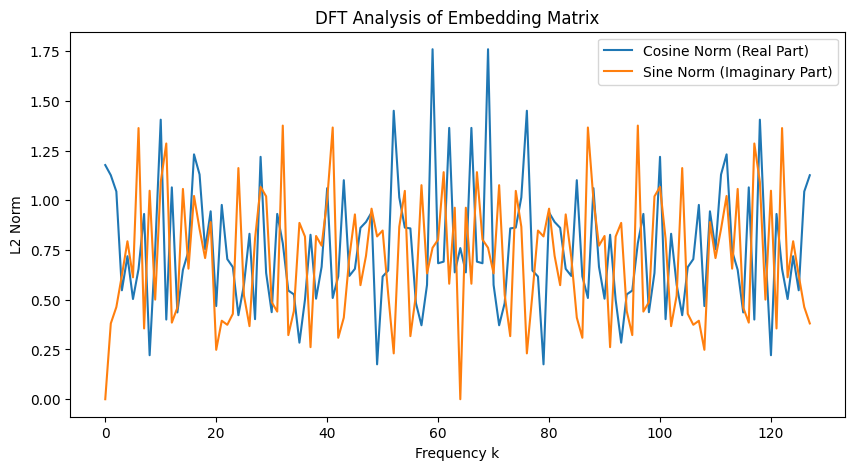

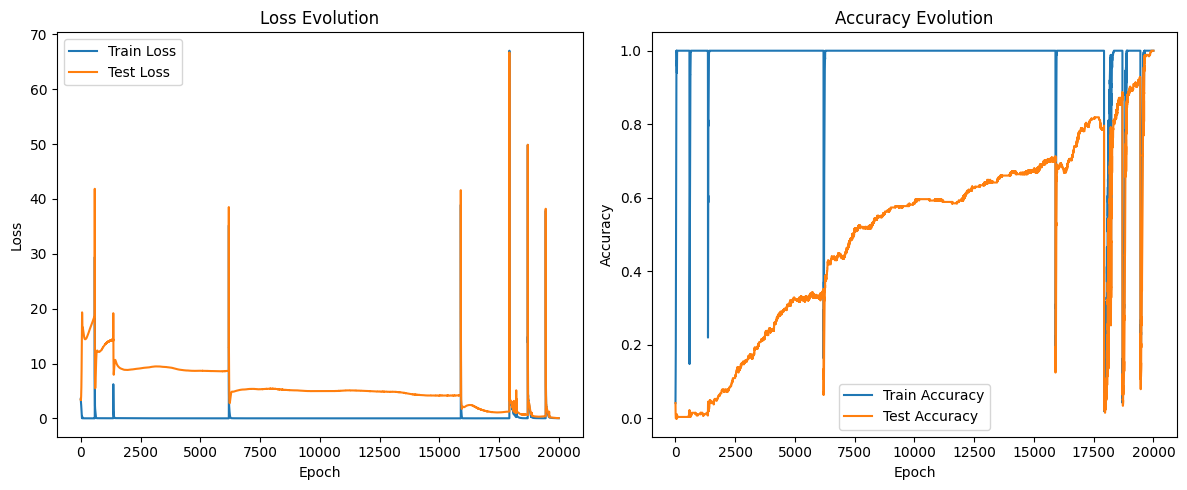

In [104]:
smol_p = 23
smol_model = Transformer(smol_p + 1, d_model=128, n_heads=4, n_layers=2, d_ff=512, max_seq_len=3)
trained_smol_model = train_model(smol_model, smol_p, proportion=0.5, num_epochs=20000)

### Very easy model

In [306]:
class TokenMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, encoder_dim, hidden_dim, encoder_depth, decoder_depth):
        """
        Args:
            vocab_size (int): Number of tokens.
            embedding_dim (int): Dimension of the token embeddings.
            encoder_dim (int): Dimension of the encoded representation.
            hidden_dim (int): Internal hidden dimension used in the MLP layers.
            encoder_depth (int): Number of layers in the encoder.
            decoder_depth (int): Number of layers in the decoder.
        """
        super(TokenMLP, self).__init__()
        # Embedding layer: maps token indices to dense vectors.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # ----- Build the Encoder -----
        # The encoder takes each token's embedding and maps it to encoder_dim.
        # If encoder_depth == 1: a single layer from embedding_dim -> encoder_dim.
        # If encoder_depth > 1: first layer goes embedding_dim -> hidden_dim, 
        # intermediate layers (if any) are hidden_dim -> hidden_dim, and the final layer is hidden_dim -> encoder_dim.
        if encoder_depth < 1:
            raise ValueError("encoder_depth must be >= 1")
        encoder_layers = []
        if encoder_depth == 1:
            encoder_layers.append(nn.Linear(embedding_dim, encoder_dim))
        else:
            # First layer: embedding_dim -> hidden_dim
            encoder_layers.append(nn.Linear(embedding_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            # Intermediate layers (if encoder_depth > 2)
            for _ in range(encoder_depth - 2):
                encoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
                encoder_layers.append(nn.ReLU())
            # Final layer: hidden_dim -> encoder_dim
            encoder_layers.append(nn.Linear(hidden_dim, encoder_dim))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # ----- Build the Decoder -----
        # The decoder maps the aggregated encoder output (of dimension encoder_dim) to logits over tokens.
        # If decoder_depth == 1: a single linear mapping from encoder_dim -> vocab_size.
        # If decoder_depth > 1: first layer goes encoder_dim -> hidden_dim, any intermediate layers are hidden_dim -> hidden_dim,
        # and the final layer is hidden_dim -> vocab_size.
        if decoder_depth < 1:
            raise ValueError("decoder_depth must be >= 1")
        decoder_layers = []
        if decoder_depth == 1:
            decoder_layers.append(nn.Linear(encoder_dim, vocab_size))
        else:
            # First decoder layer: encoder_dim -> hidden_dim
            decoder_layers.append(nn.Linear(encoder_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())
            # Intermediate layers (if any)
            for _ in range(decoder_depth - 2):
                decoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
                decoder_layers.append(nn.ReLU())
            # Final decoder layer: hidden_dim -> vocab_size
            decoder_layers.append(nn.Linear(hidden_dim, vocab_size))
        self.decoder = nn.Sequential(*decoder_layers)
        
        
    def forward(self, x):
        """
        x: LongTensor of shape (batch_size, sequence_length)
        
        The tokens are first embedded, then each token's embedding is processed through the encoder.
        The encoded representations are then aggregated (summed and divided by 2) and finally passed through the decoder.
        """
        # Look up embeddings for each token: shape (batch_size, sequence_length, embedding_dim)
        embedded = self.embedding(x)
        
        # Process each token individually through the encoder.
        # Reshape to merge batch and sequence dimensions.
        bs, seq, _ = embedded.shape
        encoded_tokens = self.encoder(embedded.view(-1, embedded.shape[-1]))
        # Reshape back to (batch_size, sequence_length, encoder_dim)
        encoded_tokens = encoded_tokens.view(bs, seq, -1)
        
        # Aggregate encoded tokens (division by 2 is on purpose, assuming sequence_length==2).
        aggregated = encoded_tokens.sum(dim=1) / 2
        
        # Pass the aggregated encoding through the decoder to get logits.
        logits = self.decoder(aggregated)
        return logits

In [331]:
def generate_easy_modular_addition_data(p: int):
    """
    Generate training data for modular addition given a prime number p.

    Assumptions:
    - Token IDs 0 to p-1 correspond to the numbers 0, 1, ..., p-1.
    - The token ID for the "=" symbol is p.
    
    Returns:
    - inputs: A tensor of shape (p*(p+1)/2, 3), where each row is (n_x, n_y, n_=).
    - labels: A tensor of shape (p*(p+1)/2,) with the result (x+y) mod p.
    """
    inputs = []
    labels = []
    equal_token = p  # The token ID for the "=" symbol.

    for x in range(p):
        for y in range(x, p):  # Only include pairs where x <= y.
            # Create the triplet (number x, number y, equal symbol token)
            inputs.append([x, y])
            # Compute the modular addition label.
            labels.append((x + y) % p)
    
    # Convert lists to torch tensors.
    inputs_tensor = torch.tensor(inputs, dtype=torch.long)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    return inputs_tensor, labels_tensor


# def generate_easy_modular_addition_data(p: int):
#     """
#     Generate training data for modular addition given a prime number p.

#     Assumptions:
#     - Token IDs 0 to p-1 correspond to the numbers 0, 1, ..., p-1.
#     - The token ID for the "=" symbol is p.
    
#     Returns:
#     - inputs: A tensor of shape (p*p, 3), where each row is (n_x, n_y, n_=).
#     - labels: A tensor of shape (p*p,) with the result (x+y) mod p.
#     """
#     inputs = []
#     labels = []
#     equal_token = p  # The token ID for the "=" symbol.

#     for x in range(p):
#         for y in range(p):
#             # Create the triplet (number x, number y, equal symbol token)
#             inputs.append([x, y])
#             # Compute the modular addition label.
#             labels.append((x + y) % p)
    
#     # Convert lists to torch tensors.
#     inputs_tensor = torch.tensor(inputs, dtype=torch.long)
#     labels_tensor = torch.tensor(labels, dtype=torch.long)
    
#     return inputs_tensor, labels_tensor

In [332]:
def train_easy_model(model, p, proportion, num_epochs):
    """
    Trains a TokenMLP model for modular addition.

    Args:
        model: The TokenMLP model to train.
        p (int): The prime number used in modular addition.
        proportion (float): Proportion of the dataset to use for training (between 0 and 1).
        num_epochs (int): Number of training epochs.
    
    Returns:
        model: The trained model.
    """
    # Generate the full dataset.
    inputs, labels = generate_easy_modular_addition_data(p)
    total_examples = inputs.shape[0]
    
    # Split the dataset into training and test sets.
    train_size = int(proportion * total_examples)
    indices = torch.randperm(total_examples)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    train_inputs = inputs[train_indices]
    train_labels = labels[train_indices]
    test_inputs = inputs[test_indices]
    test_labels = labels[test_indices]

    # Define the optimizer and loss function.
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01, betas = (0.9, 0.999))
    # Model now returns raw logits, so we directly use CrossEntropyLoss.
    criterion = nn.CrossEntropyLoss()

    # Lists for storing metrics.
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Forward pass on the training set.
        logits = model(train_inputs)  # shape: (train_size, vocab_size)
        loss = criterion(logits, train_labels)
        loss.backward()
        optimizer.step()

        # Compute training metrics.
        train_loss = loss.item()
        _, train_preds = torch.max(torch.softmax(logits, dim=1), dim=1)
        train_accuracy = (train_preds == train_labels).float().mean().item()

        # Evaluate on the test set.
        model.eval()
        with torch.no_grad():
            test_logits = model(test_inputs)
            test_loss = criterion(test_logits, test_labels).item()
            _, test_preds = torch.max(torch.softmax(test_logits, dim=1), dim=1)
            test_accuracy = (test_preds == test_labels).float().mean().item()
        model.train()

        # Record metrics.
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print metrics every 500 epochs.
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")
            
        # Every 5000 epochs, plot the encoded token representations and decision boundaries.
        if (epoch + 1) % 5000 == 0:
            with torch.no_grad():
                # Instead of using model.embedding.weight directly,
                # compute the encoded representation by passing token embeddings through the encoder.
                token_emb = model.embedding.weight  # shape: (vocab_size, embedding_dim)
                encoded = model.encoder(token_emb)    # shape: (vocab_size, encoder_dim)
            encoded_np = encoded.detach().cpu().numpy()
            num_tokens = encoded_np.shape[0]

            # Create token labels (tokens 0 to num_tokens-1)
            token_labels = [str(i) for i in range(num_tokens)]

            plt.figure(figsize=(6, 6))

            # Determine grid boundaries based on the encoded representations.
            margin = 0.5
            x_min, x_max = encoded_np[:, 0].min() - margin, encoded_np[:, 0].max() + margin
            y_min, y_max = encoded_np[:, 1].min() - margin, encoded_np[:, 1].max() + margin

            # Create a grid of points in the encoder space (assumed to be 2D).
            grid_resolution = 200
            x_vals = np.linspace(x_min, x_max, grid_resolution)
            y_vals = np.linspace(y_min, y_max, grid_resolution)
            xx, yy = np.meshgrid(x_vals, y_vals)
            grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # shape: (grid_resolution^2, 2)

            # Evaluate the function that maps from the encoder space to the logits/probabilities.
            grid_tensor = torch.tensor(grid, dtype=torch.float, device=encoded.device)
            with torch.no_grad():
                # Pass grid points through the decoder to get logits.
                logits_grid = model.decoder(grid_tensor)  # shape: (N, vocab_size)
                probs_grid = torch.softmax(logits_grid, dim=1)
                preds = torch.argmax(probs_grid, dim=1)
            preds_np = preds.cpu().numpy().reshape(xx.shape)

            # Plot the decision regions.
            plt.contourf(xx, yy, preds_np, alpha=0.5, cmap="viridis")

            # Overlay the token labels at their encoded positions.
            for i, enc in enumerate(encoded_np):
                x = enc[0]
                y = enc[1] if enc.shape[0] >= 2 else 0
                plt.text(x, y, token_labels[i], fontsize=12, ha='center', va='center', color='white')

            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.title(f"Encoded Token Representations and Evaluation at Epoch {epoch+1}")
            plt.grid(True)
            plt.show()
         
    # Plot the evolution of loss and accuracy.
    epochs_range = range(1, num_epochs + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Loss evolution.
    axs[0].plot(epochs_range, train_losses, label="Train Loss")
    axs[0].plot(epochs_range, test_losses, label="Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss Evolution")
    axs[0].legend()

    # Accuracy evolution.
    axs[1].plot(epochs_range, train_accuracies, label="Train Accuracy")
    axs[1].plot(epochs_range, test_accuracies, label="Test Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy Evolution")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return model

Epoch 500/50000, Train Loss: 0.1127, Test Loss: 0.3481, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 1000/50000, Train Loss: 0.0127, Test Loss: 0.3447, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 1500/50000, Train Loss: 0.0040, Test Loss: 0.4269, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 2000/50000, Train Loss: 0.0019, Test Loss: 0.4895, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 2500/50000, Train Loss: 0.0010, Test Loss: 0.5473, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 3000/50000, Train Loss: 0.0006, Test Loss: 0.5962, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 3500/50000, Train Loss: 0.0004, Test Loss: 0.6393, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 4000/50000, Train Loss: 0.0003, Test Loss: 0.6778, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 4500/50000, Train Loss: 0.0002, Test Loss: 0.7131, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 5000/50000, Train Loss: 0.0001, Test Loss: 0.7473, Train Acc: 1.0000, Test Acc: 0.8378


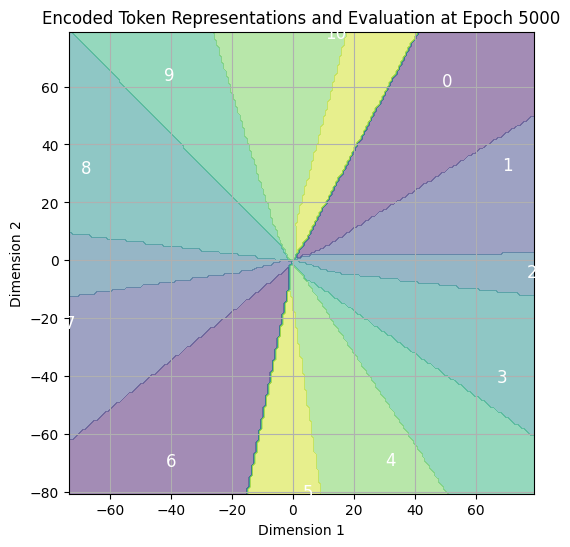

Epoch 5500/50000, Train Loss: 0.0001, Test Loss: 0.7817, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 6000/50000, Train Loss: 0.0001, Test Loss: 0.8145, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 6500/50000, Train Loss: 0.0001, Test Loss: 0.8467, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 7000/50000, Train Loss: 0.0000, Test Loss: 0.8790, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 7500/50000, Train Loss: 0.0000, Test Loss: 0.9106, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 8000/50000, Train Loss: 0.0000, Test Loss: 0.9424, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 8500/50000, Train Loss: 0.0000, Test Loss: 0.9717, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 9000/50000, Train Loss: 0.0000, Test Loss: 1.0033, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 9500/50000, Train Loss: 0.0000, Test Loss: 1.0362, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 10000/50000, Train Loss: 0.0000, Test Loss: 1.0691, Train Acc: 1.0000, Test Acc: 0.8378


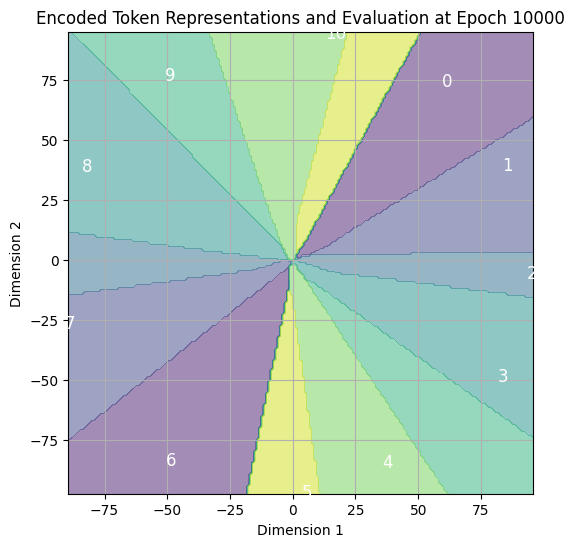

Epoch 10500/50000, Train Loss: 0.0000, Test Loss: 1.1022, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 11000/50000, Train Loss: 0.0000, Test Loss: 1.1362, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 11500/50000, Train Loss: 0.0000, Test Loss: 1.1706, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 12000/50000, Train Loss: 0.0000, Test Loss: 1.1941, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 12500/50000, Train Loss: 0.0000, Test Loss: 1.2338, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 13000/50000, Train Loss: 0.0000, Test Loss: 1.2658, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 13500/50000, Train Loss: 0.0000, Test Loss: 1.3175, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 14000/50000, Train Loss: 0.0000, Test Loss: 1.3211, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 14500/50000, Train Loss: 0.0000, Test Loss: 1.3385, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 15000/50000, Train Loss: 0.0000, Test Loss: 1.3675, Train Acc: 1.0000, Test Acc: 0.8378


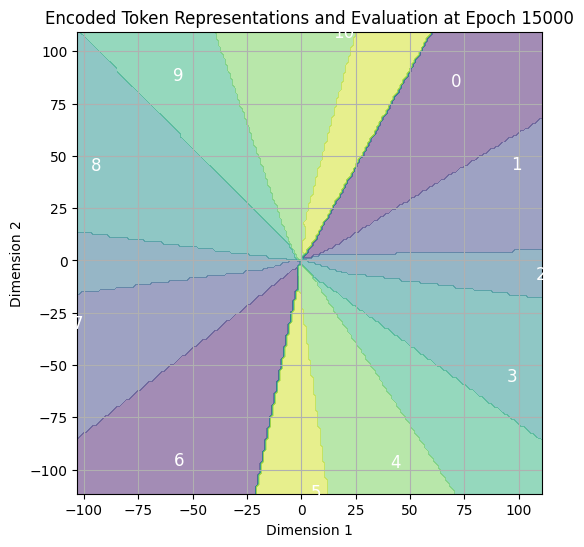

Epoch 15500/50000, Train Loss: 0.0000, Test Loss: 1.3920, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 16000/50000, Train Loss: 0.0000, Test Loss: 1.4091, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 16500/50000, Train Loss: 0.0000, Test Loss: 1.4640, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 17000/50000, Train Loss: 0.0000, Test Loss: 1.4254, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 17500/50000, Train Loss: 0.0000, Test Loss: 1.4351, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 18000/50000, Train Loss: 0.0000, Test Loss: 1.4314, Train Acc: 1.0000, Test Acc: 0.7838
Epoch 18500/50000, Train Loss: 0.0000, Test Loss: 1.4130, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 19000/50000, Train Loss: 0.0000, Test Loss: 1.6403, Train Acc: 1.0000, Test Acc: 0.7838
Epoch 19500/50000, Train Loss: 0.0000, Test Loss: 2.1176, Train Acc: 1.0000, Test Acc: 0.7838
Epoch 20000/50000, Train Loss: 0.0000, Test Loss: 2.5491, Train Acc: 1.0000, Test Acc: 0.7838


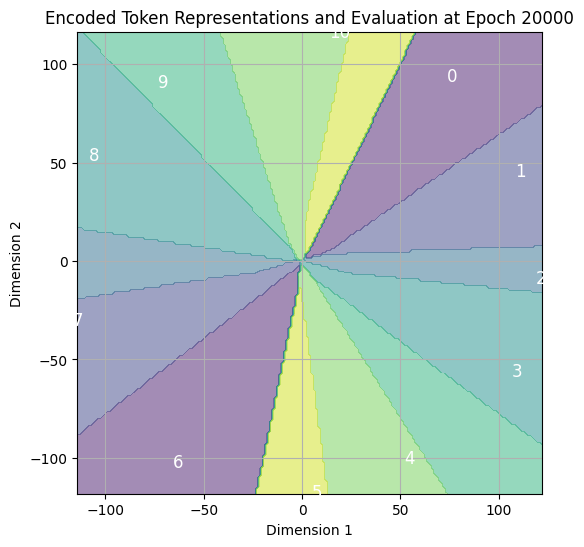

Epoch 20500/50000, Train Loss: 0.0000, Test Loss: 2.3130, Train Acc: 1.0000, Test Acc: 0.7838
Epoch 21000/50000, Train Loss: 0.0000, Test Loss: 2.5774, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 21500/50000, Train Loss: 0.0000, Test Loss: 2.8472, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 22000/50000, Train Loss: 0.0000, Test Loss: 3.2446, Train Acc: 1.0000, Test Acc: 0.8378
Epoch 22500/50000, Train Loss: 0.0000, Test Loss: 2.6678, Train Acc: 1.0000, Test Acc: 0.7838
Epoch 23000/50000, Train Loss: 0.0000, Test Loss: 3.8789, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 23500/50000, Train Loss: 0.0000, Test Loss: 7.1360, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 24000/50000, Train Loss: 0.0000, Test Loss: 6.2778, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 24500/50000, Train Loss: 0.0000, Test Loss: 6.1776, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 25000/50000, Train Loss: 0.0000, Test Loss: 6.1272, Train Acc: 1.0000, Test Acc: 0.8649


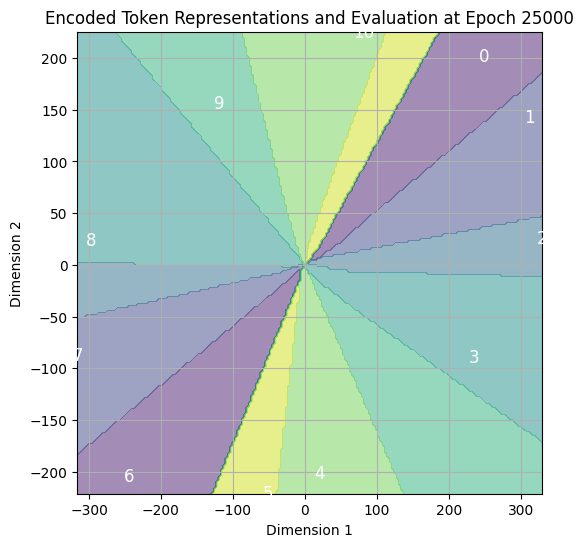

Epoch 25500/50000, Train Loss: 0.0000, Test Loss: 6.0869, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 26000/50000, Train Loss: 0.0000, Test Loss: 6.0524, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 26500/50000, Train Loss: 0.0000, Test Loss: 6.0229, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 27000/50000, Train Loss: 0.0000, Test Loss: 5.9984, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 27500/50000, Train Loss: 0.0000, Test Loss: 5.9792, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 28000/50000, Train Loss: 0.0000, Test Loss: 5.9650, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 28500/50000, Train Loss: 0.0000, Test Loss: 5.9563, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 29000/50000, Train Loss: 0.0000, Test Loss: 5.9549, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 29500/50000, Train Loss: 0.0000, Test Loss: 6.0004, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 30000/50000, Train Loss: 0.0000, Test Loss: 6.1679, Train Acc: 1.0000, Test Acc: 0.8108


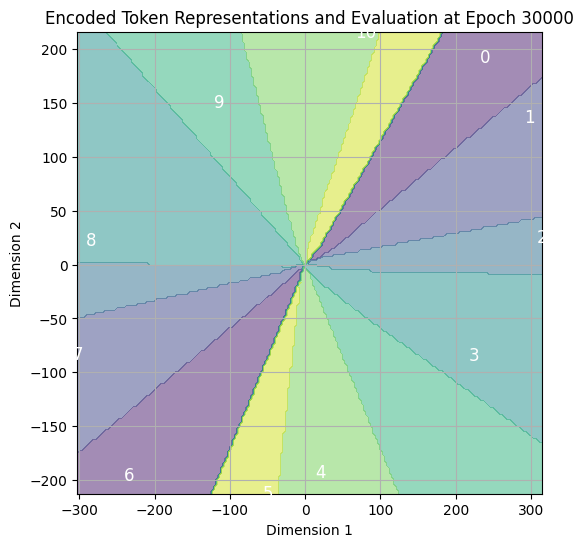

Epoch 30500/50000, Train Loss: 0.0000, Test Loss: 6.4023, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 31000/50000, Train Loss: 0.0000, Test Loss: 6.6810, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 31500/50000, Train Loss: 0.0000, Test Loss: 6.9922, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 32000/50000, Train Loss: 0.0000, Test Loss: 7.2188, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 32500/50000, Train Loss: 0.0000, Test Loss: 7.3463, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 33000/50000, Train Loss: 0.0000, Test Loss: 7.5522, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 33500/50000, Train Loss: 0.0000, Test Loss: 7.7989, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 34000/50000, Train Loss: 0.0000, Test Loss: 8.0812, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 34500/50000, Train Loss: 0.0000, Test Loss: 8.3004, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 35000/50000, Train Loss: 0.0000, Test Loss: 8.2479, Train Acc: 1.0000, Test Acc: 0.8108


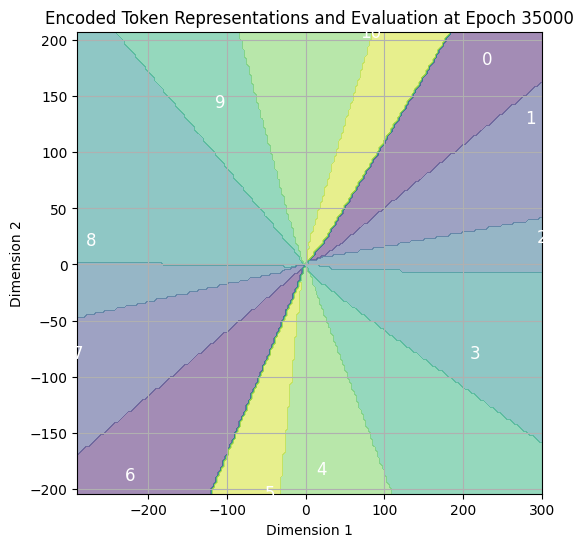

Epoch 35500/50000, Train Loss: 0.0000, Test Loss: 8.0688, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 36000/50000, Train Loss: 0.0000, Test Loss: 7.9720, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 36500/50000, Train Loss: 0.0000, Test Loss: 7.8977, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 37000/50000, Train Loss: 0.0000, Test Loss: 7.7532, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 37500/50000, Train Loss: 0.0000, Test Loss: 7.4821, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 38000/50000, Train Loss: 0.0000, Test Loss: 7.1624, Train Acc: 1.0000, Test Acc: 0.7568
Epoch 38500/50000, Train Loss: 0.0000, Test Loss: 6.9558, Train Acc: 1.0000, Test Acc: 0.7568
Epoch 39000/50000, Train Loss: 0.0000, Test Loss: 6.9475, Train Acc: 1.0000, Test Acc: 0.7568
Epoch 39500/50000, Train Loss: 0.0000, Test Loss: 7.0272, Train Acc: 1.0000, Test Acc: 0.7568
Epoch 40000/50000, Train Loss: 0.0000, Test Loss: 7.2144, Train Acc: 1.0000, Test Acc: 0.7568


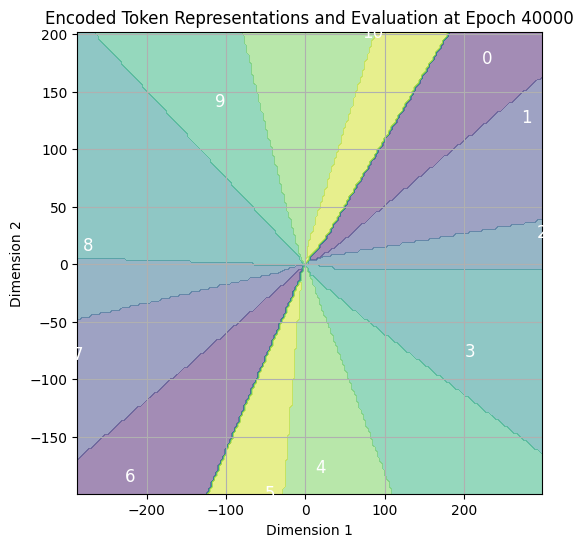

Epoch 40500/50000, Train Loss: 0.0000, Test Loss: 6.8430, Train Acc: 1.0000, Test Acc: 0.7568
Epoch 41000/50000, Train Loss: 0.0000, Test Loss: 6.4620, Train Acc: 1.0000, Test Acc: 0.7568
Epoch 41500/50000, Train Loss: 0.0000, Test Loss: 6.1974, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 42000/50000, Train Loss: 0.0000, Test Loss: 6.5581, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 42500/50000, Train Loss: 0.0000, Test Loss: 6.9912, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 43000/50000, Train Loss: 0.0000, Test Loss: 7.5059, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 43500/50000, Train Loss: 0.0000, Test Loss: 8.2286, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 44000/50000, Train Loss: 0.0000, Test Loss: 9.1280, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 44500/50000, Train Loss: 0.0000, Test Loss: 10.0588, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 45000/50000, Train Loss: 0.0000, Test Loss: 10.1901, Train Acc: 1.0000, Test Acc: 0.8108


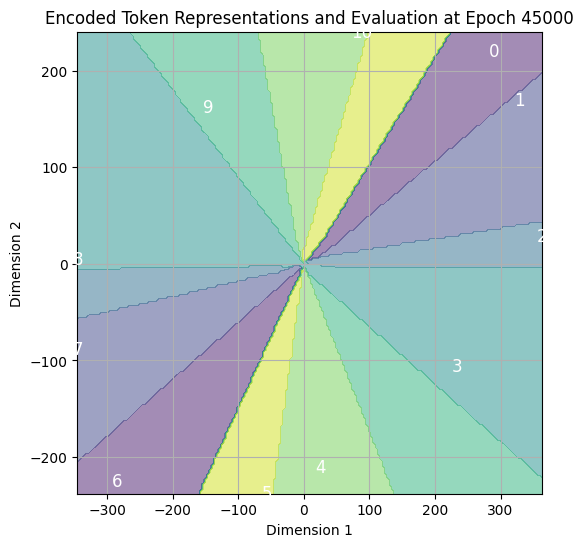

Epoch 45500/50000, Train Loss: 0.0000, Test Loss: 13.0998, Train Acc: 1.0000, Test Acc: 0.7027
Epoch 46000/50000, Train Loss: 0.0000, Test Loss: 16.1396, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 46500/50000, Train Loss: 0.0000, Test Loss: 19.5618, Train Acc: 1.0000, Test Acc: 0.7568
Epoch 47000/50000, Train Loss: 0.0000, Test Loss: 32.6851, Train Acc: 1.0000, Test Acc: 0.7568
Epoch 47500/50000, Train Loss: 0.0000, Test Loss: 25.3878, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 48000/50000, Train Loss: 0.0000, Test Loss: 25.1873, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 48500/50000, Train Loss: 0.0000, Test Loss: 24.9973, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 49000/50000, Train Loss: 0.0000, Test Loss: 24.8126, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 49500/50000, Train Loss: 0.0000, Test Loss: 24.6294, Train Acc: 1.0000, Test Acc: 0.8108
Epoch 50000/50000, Train Loss: 0.0000, Test Loss: 24.4485, Train Acc: 1.0000, Test Acc: 0.8108


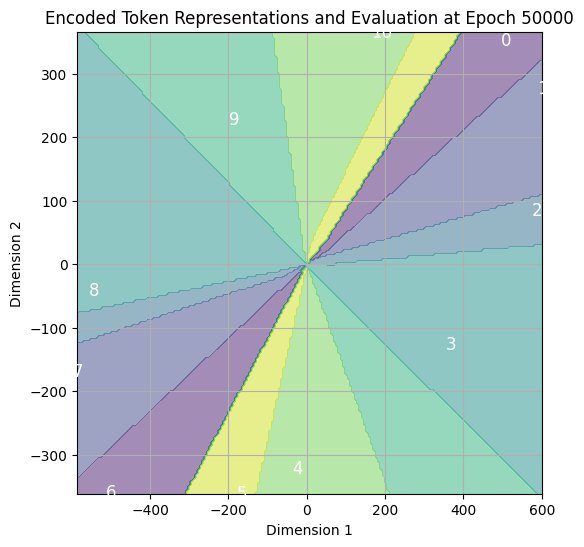

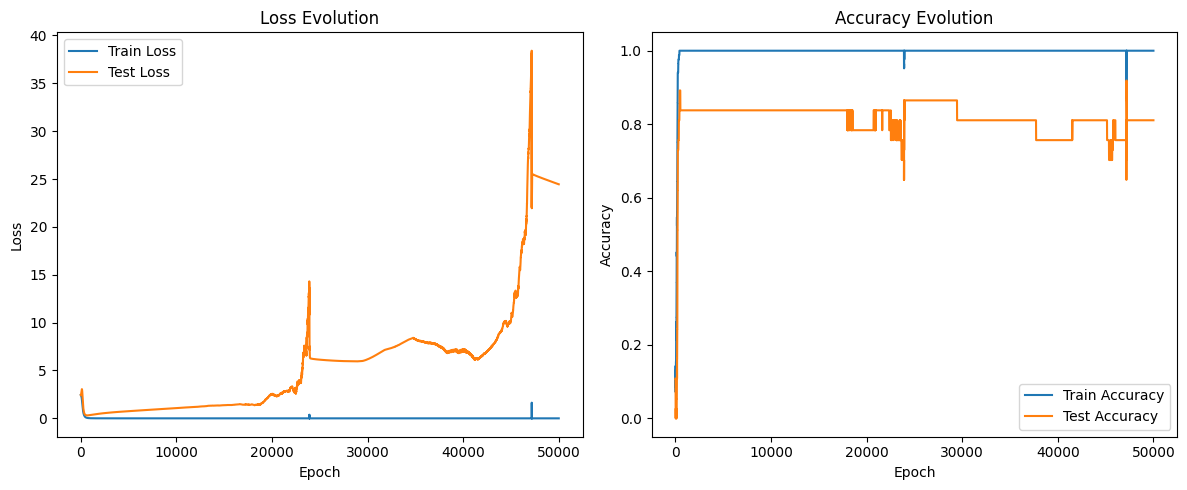

In [311]:
easy_p = 11
easy_model = TokenMLP(easy_p, embedding_dim=64, encoder_dim=2, hidden_dim=128, encoder_depth=2, decoder_depth=2) # vocab_size, embedding_dim, encoder_dim, hidden_dim, encoder_depth, decoder_depth
trained_easy_model = train_easy_model(easy_model, easy_p, proportion=0.7, num_epochs=50000)

In [333]:
def train_easy_model2(model, p, proportion, num_epochs): #it adds the values of the colors
    """
    Trains a TokenMLP model for modular addition.

    Args:
        model: The TokenMLP model to train.
        p (int): The prime number used in modular addition.
        proportion (float): Proportion of the dataset to use for training (between 0 and 1).
        num_epochs (int): Number of training epochs.
    
    Returns:
        model: The trained model.
    """
    # Generate the full dataset.
    inputs, labels = generate_easy_modular_addition_data(p)
    total_examples = inputs.shape[0]
    
    # Split the dataset into training and test sets.
    train_size = int(proportion * total_examples)
    indices = torch.randperm(total_examples)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    train_inputs = inputs[train_indices]
    train_labels = labels[train_indices]
    test_inputs = inputs[test_indices]
    test_labels = labels[test_indices]

    # Define the optimizer and loss function.
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01, betas=(0.9, 0.999))
    # Model now returns raw logits, so we directly use CrossEntropyLoss.
    criterion = nn.CrossEntropyLoss()

    # Lists for storing metrics.
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    count_train1 = 0
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Forward pass on the training set.
        logits = model(train_inputs)  # shape: (train_size, vocab_size)
        loss = criterion(logits, train_labels)
        loss.backward()
        optimizer.step()

        # Compute training metrics.
        train_loss = loss.item()
        _, train_preds = torch.max(torch.softmax(logits, dim=1), dim=1)
        train_accuracy = (train_preds == train_labels).float().mean().item()

        if train_accuracy == 1:
            count_train1 += 1


        # Evaluate on the test set.
        model.eval()
        with torch.no_grad():
            test_logits = model(test_inputs)
            test_loss = criterion(test_logits, test_labels).item()
            _, test_preds = torch.max(torch.softmax(test_logits, dim=1), dim=1)
            test_accuracy = (test_preds == test_labels).float().mean().item()
        model.train()

        # Record metrics.
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print metrics every 500 epochs.
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")
        
        if count_train1 == 1:
            with torch.no_grad():
                # Instead of using model.embedding.weight directly,
                # compute the encoded representation by passing token embeddings through the encoder.
                token_emb = model.embedding.weight  # shape: (vocab_size, embedding_dim)
                encoded = model.encoder(token_emb)    # shape: (vocab_size, encoder_dim)
            encoded_np = encoded.detach().cpu().numpy()
            num_tokens = encoded_np.shape[0]

            # Create token labels (tokens 0 to num_tokens-1)
            token_labels = [str(i) for i in range(num_tokens)]

            plt.figure(figsize=(6, 6))

            # Determine grid boundaries based on the encoded representations.
            margin = 0.5
            x_min, x_max = encoded_np[:, 0].min() - margin, encoded_np[:, 0].max() + margin
            y_min, y_max = encoded_np[:, 1].min() - margin, encoded_np[:, 1].max() + margin

            # Create a grid of points in the encoder space (assumed to be 2D).
            grid_resolution = 200
            x_vals = np.linspace(x_min, x_max, grid_resolution)
            y_vals = np.linspace(y_min, y_max, grid_resolution)
            xx, yy = np.meshgrid(x_vals, y_vals)
            grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # shape: (grid_resolution^2, 2)

            # Evaluate the function that maps from the encoder space to the logits/probabilities.
            grid_tensor = torch.tensor(grid, dtype=torch.float, device=encoded.device)
            with torch.no_grad():
                # Pass grid points through the decoder to get logits.
                logits_grid = model.decoder(grid_tensor)        # shape: (N, vocab_size)
                probs_grid = torch.softmax(logits_grid, dim=1)  # shape: (N, vocab_size)
                preds = torch.argmax(probs_grid, dim=1)         
            preds_np = preds.cpu().numpy().reshape(xx.shape)

            # Create discrete levels for the colormap.
            levels = np.linspace(-0.5, num_tokens - 0.5, num_tokens + 1)

            # Plot the decision regions with these levels.
            contour = plt.contourf(xx, yy, preds_np, levels=levels, alpha=0.5, cmap="viridis")

            # Add a colorbar with ticks placed at each integer value.
            cbar = plt.colorbar(contour, ticks=np.arange(num_tokens))
            cbar.ax.set_yticklabels(token_labels)

            # Overlay the token labels at their encoded positions.
            for i, enc in enumerate(encoded_np):
                x = enc[0]
                y = enc[1] if enc.shape[0] >= 2 else 0
                plt.text(x, y, token_labels[i], fontsize=12, ha='center', va='center', color='white')

            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.title(f"Encoded Token Representations and Evaluation at Epoch {epoch+1}")
            plt.grid(True)
            plt.show()


            
        # Every 5000 epochs, plot the encoded token representations and decision boundaries.
        if (epoch + 1) % 5000 == 0:
            with torch.no_grad():
                # Instead of using model.embedding.weight directly,
                # compute the encoded representation by passing token embeddings through the encoder.
                token_emb = model.embedding.weight  # shape: (vocab_size, embedding_dim)
                encoded = model.encoder(token_emb)    # shape: (vocab_size, encoder_dim)
            encoded_np = encoded.detach().cpu().numpy()
            num_tokens = encoded_np.shape[0]

            # Create token labels (tokens 0 to num_tokens-1)
            token_labels = [str(i) for i in range(num_tokens)]

            plt.figure(figsize=(6, 6))

            # Determine grid boundaries based on the encoded representations.
            margin = 0.5
            x_min, x_max = encoded_np[:, 0].min() - margin, encoded_np[:, 0].max() + margin
            y_min, y_max = encoded_np[:, 1].min() - margin, encoded_np[:, 1].max() + margin

            # Create a grid of points in the encoder space (assumed to be 2D).
            grid_resolution = 200
            x_vals = np.linspace(x_min, x_max, grid_resolution)
            y_vals = np.linspace(y_min, y_max, grid_resolution)
            xx, yy = np.meshgrid(x_vals, y_vals)
            grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # shape: (grid_resolution^2, 2)

            # Evaluate the function that maps from the encoder space to the logits/probabilities.
            grid_tensor = torch.tensor(grid, dtype=torch.float, device=encoded.device)
            with torch.no_grad():
                # Pass grid points through the decoder to get logits.
                logits_grid = model.decoder(grid_tensor)        # shape: (N, vocab_size)
                probs_grid = torch.softmax(logits_grid, dim=1)  # shape: (N, vocab_size)
                preds = torch.argmax(probs_grid, dim=1)         
            preds_np = preds.cpu().numpy().reshape(xx.shape)

            # Create discrete levels for the colormap.
            levels = np.linspace(-0.5, num_tokens - 0.5, num_tokens + 1)

            # Plot the decision regions with these levels.
            contour = plt.contourf(xx, yy, preds_np, levels=levels, alpha=0.5, cmap="viridis")

            # Add a colorbar with ticks placed at each integer value.
            cbar = plt.colorbar(contour, ticks=np.arange(num_tokens))
            cbar.ax.set_yticklabels(token_labels)

            # Overlay the token labels at their encoded positions.
            for i, enc in enumerate(encoded_np):
                x = enc[0]
                y = enc[1] if enc.shape[0] >= 2 else 0
                plt.text(x, y, token_labels[i], fontsize=12, ha='center', va='center', color='white')

            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.title(f"Encoded Token Representations and Evaluation at Epoch {epoch+1}")
            plt.grid(True)
            plt.show()
         
    # Plot the evolution of loss and accuracy.
    epochs_range = range(1, num_epochs + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Loss evolution.
    axs[0].plot(epochs_range, train_losses, label="Train Loss")
    axs[0].plot(epochs_range, test_losses, label="Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss Evolution")
    axs[0].legend()

    # Accuracy evolution.
    axs[1].plot(epochs_range, train_accuracies, label="Train Accuracy")
    axs[1].plot(epochs_range, test_accuracies, label="Test Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy Evolution")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return model


Epoch 500/50000, Train Loss: 0.1055, Test Loss: 0.3638, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 1000/50000, Train Loss: 0.0119, Test Loss: 0.2432, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 1500/50000, Train Loss: 0.0037, Test Loss: 0.2709, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 2000/50000, Train Loss: 0.0017, Test Loss: 0.3068, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 2500/50000, Train Loss: 0.0009, Test Loss: 0.3366, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 3000/50000, Train Loss: 0.0006, Test Loss: 0.3594, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 3500/50000, Train Loss: 0.0004, Test Loss: 0.3845, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 4000/50000, Train Loss: 0.0002, Test Loss: 0.4098, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 4500/50000, Train Loss: 0.0002, Test Loss: 0.4340, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 5000/50000, Train Loss: 0.0001, Test Loss: 0.4544, Train Acc: 1.0000, Test Acc: 0.9189


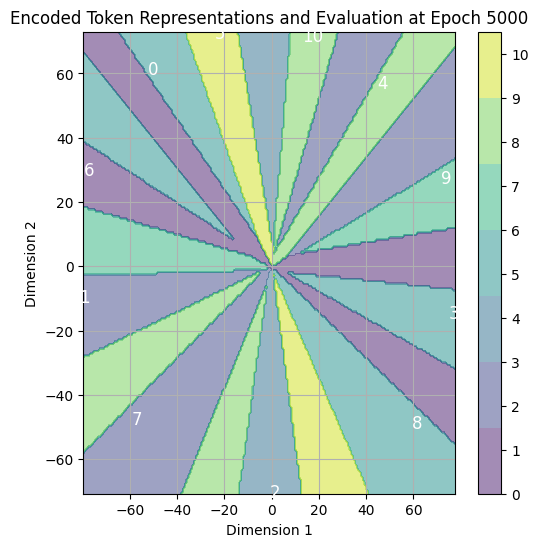

Epoch 5500/50000, Train Loss: 0.0001, Test Loss: 0.4723, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 6000/50000, Train Loss: 0.0001, Test Loss: 0.4898, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 6500/50000, Train Loss: 0.0000, Test Loss: 0.5054, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 7000/50000, Train Loss: 0.0000, Test Loss: 0.5183, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 7500/50000, Train Loss: 0.0000, Test Loss: 0.5325, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 8000/50000, Train Loss: 0.0000, Test Loss: 0.5464, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 8500/50000, Train Loss: 0.0000, Test Loss: 0.5611, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 9000/50000, Train Loss: 0.0000, Test Loss: 0.5751, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 9500/50000, Train Loss: 0.0000, Test Loss: 0.5878, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 10000/50000, Train Loss: 0.0000, Test Loss: 0.5994, Train Acc: 1.0000, Test Acc: 0.9189


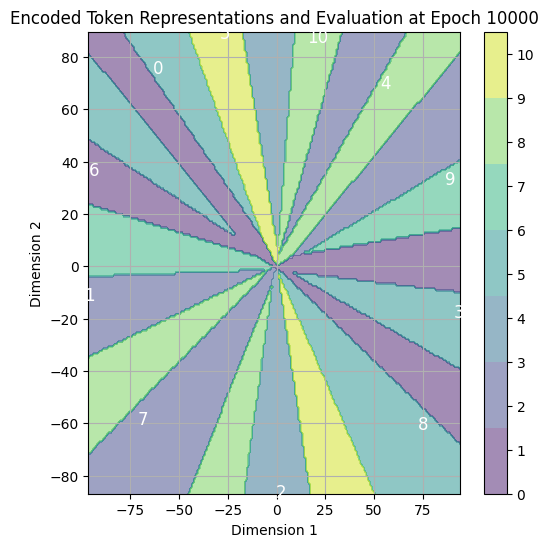

Epoch 10500/50000, Train Loss: 0.0000, Test Loss: 0.6124, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 11000/50000, Train Loss: 0.0000, Test Loss: 0.6214, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 11500/50000, Train Loss: 0.0000, Test Loss: 0.6352, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 12000/50000, Train Loss: 0.0000, Test Loss: 0.6298, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 12500/50000, Train Loss: 0.0000, Test Loss: 0.6538, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 13000/50000, Train Loss: 0.0000, Test Loss: 0.6634, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 13500/50000, Train Loss: 0.0000, Test Loss: 0.6668, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 14000/50000, Train Loss: 0.0000, Test Loss: 0.6943, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 14500/50000, Train Loss: 0.0000, Test Loss: 0.7204, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 15000/50000, Train Loss: 0.0000, Test Loss: 0.7039, Train Acc: 1.0000, Test Acc: 0.9189


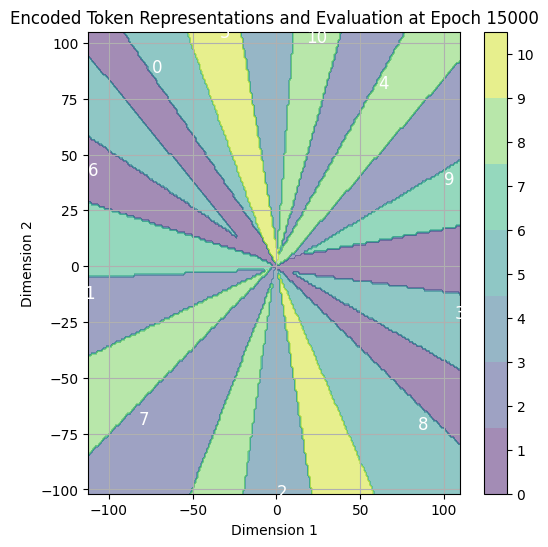

Epoch 15500/50000, Train Loss: 0.0000, Test Loss: 0.7888, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 16000/50000, Train Loss: 0.0000, Test Loss: 0.7495, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 16500/50000, Train Loss: 0.0000, Test Loss: 0.7306, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 17000/50000, Train Loss: 0.0000, Test Loss: 0.8075, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 17500/50000, Train Loss: 0.0000, Test Loss: 0.9096, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 18000/50000, Train Loss: 0.0000, Test Loss: 1.0018, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 18500/50000, Train Loss: 0.0000, Test Loss: 1.0500, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 19000/50000, Train Loss: 0.0000, Test Loss: 1.0368, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 19500/50000, Train Loss: 0.0000, Test Loss: 0.9352, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 20000/50000, Train Loss: 0.0000, Test Loss: 0.8861, Train Acc: 1.0000, Test Acc: 0.9189


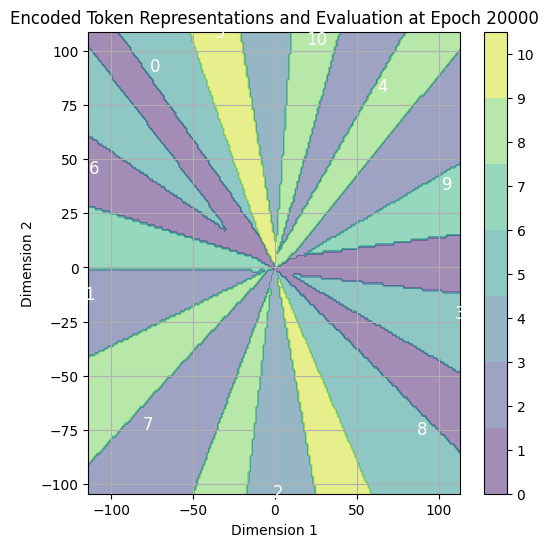

Epoch 20500/50000, Train Loss: 0.0000, Test Loss: 0.8373, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 21000/50000, Train Loss: 0.0000, Test Loss: 0.6298, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 21500/50000, Train Loss: 0.0000, Test Loss: 0.4682, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 22000/50000, Train Loss: 0.0000, Test Loss: 0.3555, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 22500/50000, Train Loss: 0.0000, Test Loss: 0.4158, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 23000/50000, Train Loss: 0.0000, Test Loss: 0.6961, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 23500/50000, Train Loss: 0.0000, Test Loss: 1.5617, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 24000/50000, Train Loss: 0.0000, Test Loss: 1.5512, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 24500/50000, Train Loss: 0.0000, Test Loss: 1.5427, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 25000/50000, Train Loss: 0.0000, Test Loss: 1.5350, Train Acc: 1.0000, Test Acc: 0.8919


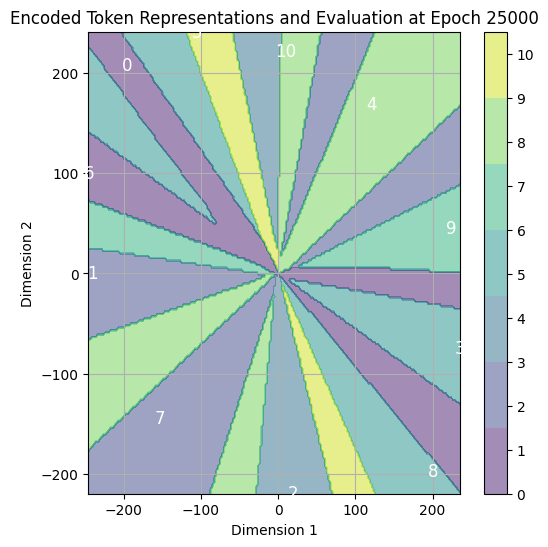

Epoch 25500/50000, Train Loss: 0.0000, Test Loss: 1.5289, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 26000/50000, Train Loss: 0.0000, Test Loss: 1.5232, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 26500/50000, Train Loss: 0.0000, Test Loss: 1.5183, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 27000/50000, Train Loss: 0.0000, Test Loss: 1.5113, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 27500/50000, Train Loss: 0.0000, Test Loss: 1.5042, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 28000/50000, Train Loss: 0.0000, Test Loss: 1.4973, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 28500/50000, Train Loss: 0.0000, Test Loss: 1.4885, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 29000/50000, Train Loss: 0.0000, Test Loss: 1.4773, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 29500/50000, Train Loss: 0.0000, Test Loss: 1.4665, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 30000/50000, Train Loss: 0.0000, Test Loss: 1.4485, Train Acc: 1.0000, Test Acc: 0.8919


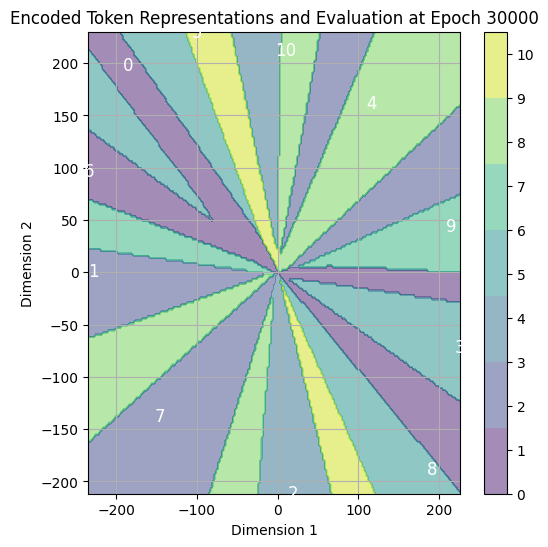

Epoch 30500/50000, Train Loss: 0.0000, Test Loss: 1.4289, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 31000/50000, Train Loss: 0.0000, Test Loss: 1.4098, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 31500/50000, Train Loss: 0.0000, Test Loss: 1.3890, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 32000/50000, Train Loss: 0.0000, Test Loss: 1.3613, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 32500/50000, Train Loss: 0.0000, Test Loss: 1.3448, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 33000/50000, Train Loss: 0.0000, Test Loss: 1.3304, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 33500/50000, Train Loss: 0.0000, Test Loss: 1.3168, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 34000/50000, Train Loss: 0.0000, Test Loss: 1.2931, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 34500/50000, Train Loss: 0.0000, Test Loss: 1.2467, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 35000/50000, Train Loss: 0.0000, Test Loss: 1.1942, Train Acc: 1.0000, Test Acc: 0.8919


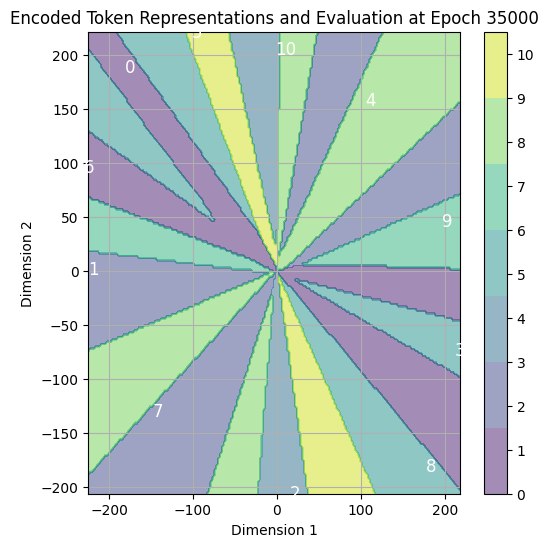

Epoch 35500/50000, Train Loss: 0.0000, Test Loss: 1.1408, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 36000/50000, Train Loss: 0.0000, Test Loss: 1.0920, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 36500/50000, Train Loss: 0.0000, Test Loss: 1.0108, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 37000/50000, Train Loss: 0.0000, Test Loss: 0.9587, Train Acc: 1.0000, Test Acc: 0.9459
Epoch 37500/50000, Train Loss: 0.0000, Test Loss: 1.0214, Train Acc: 1.0000, Test Acc: 0.9459
Epoch 38000/50000, Train Loss: 0.0000, Test Loss: 1.0292, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 38500/50000, Train Loss: 0.0000, Test Loss: 1.0198, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 39000/50000, Train Loss: 0.0000, Test Loss: 1.0145, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 39500/50000, Train Loss: 0.0000, Test Loss: 1.0028, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 40000/50000, Train Loss: 0.0000, Test Loss: 1.4089, Train Acc: 1.0000, Test Acc: 0.8919


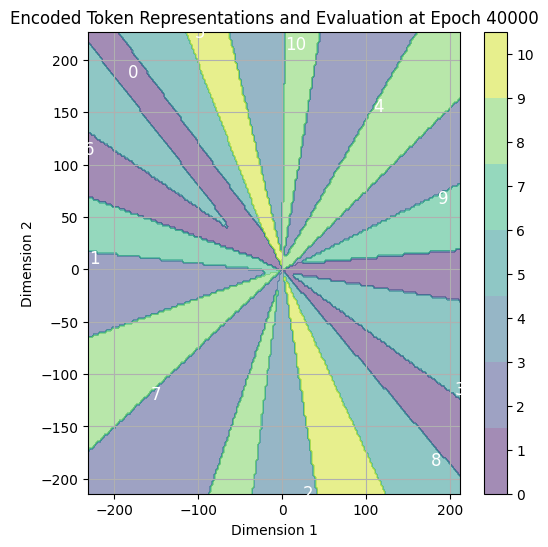

Epoch 40500/50000, Train Loss: 0.0000, Test Loss: 1.4860, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 41000/50000, Train Loss: 0.0000, Test Loss: 1.7004, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 41500/50000, Train Loss: 0.0000, Test Loss: 1.8199, Train Acc: 1.0000, Test Acc: 0.9459
Epoch 42000/50000, Train Loss: 0.0000, Test Loss: 2.0484, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 42500/50000, Train Loss: 0.0000, Test Loss: 2.2982, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 43000/50000, Train Loss: 0.0000, Test Loss: 2.4429, Train Acc: 1.0000, Test Acc: 0.9189
Epoch 43500/50000, Train Loss: 0.0000, Test Loss: 1.7403, Train Acc: 1.0000, Test Acc: 0.8649
Epoch 44000/50000, Train Loss: 0.0000, Test Loss: 1.1319, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 44500/50000, Train Loss: 0.0000, Test Loss: 0.4625, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 45000/50000, Train Loss: 0.0002, Test Loss: 1.9545, Train Acc: 1.0000, Test Acc: 0.8919


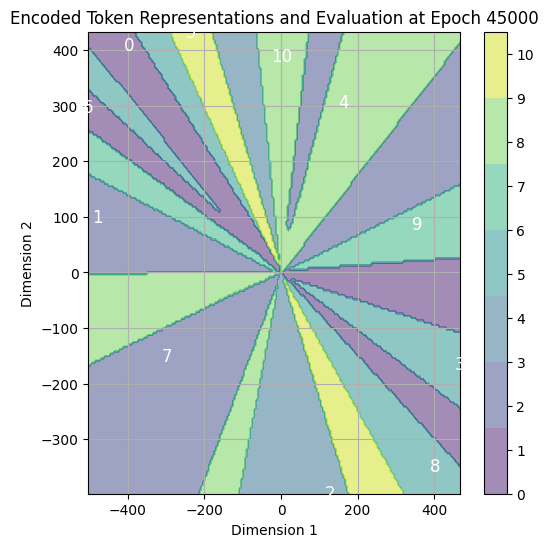

Epoch 45500/50000, Train Loss: 0.0000, Test Loss: 1.9135, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 46000/50000, Train Loss: 0.0000, Test Loss: 1.9043, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 46500/50000, Train Loss: 0.0000, Test Loss: 1.8996, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 47000/50000, Train Loss: 0.0000, Test Loss: 1.8956, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 47500/50000, Train Loss: 0.0000, Test Loss: 1.8930, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 48000/50000, Train Loss: 0.0000, Test Loss: 1.8900, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 48500/50000, Train Loss: 0.0000, Test Loss: 1.8867, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 49000/50000, Train Loss: 0.0000, Test Loss: 1.8833, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 49500/50000, Train Loss: 0.0000, Test Loss: 1.8779, Train Acc: 1.0000, Test Acc: 0.8919
Epoch 50000/50000, Train Loss: 0.0000, Test Loss: 1.8720, Train Acc: 1.0000, Test Acc: 0.8919


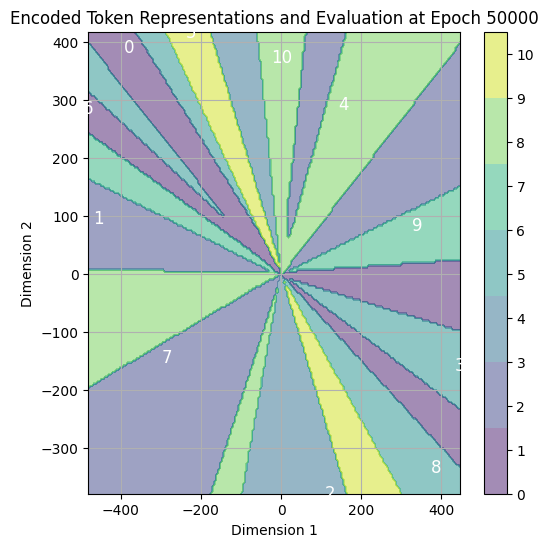

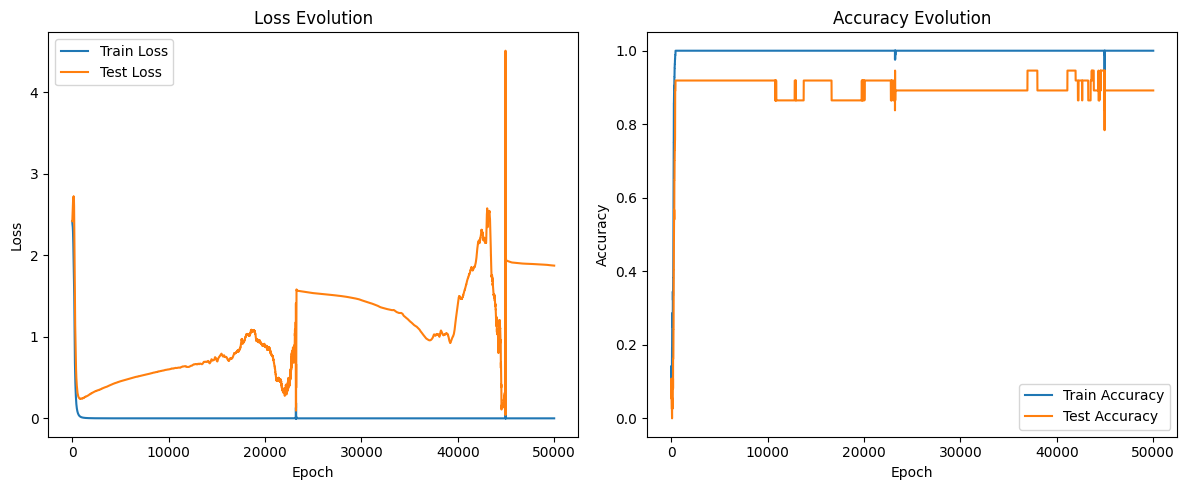

In [313]:
easy_p2 = 11
easy_model2 = TokenMLP(easy_p2, embedding_dim=64, encoder_dim=2, hidden_dim=128, encoder_depth=2, decoder_depth=2) # vocab_size, embedding_dim, encoder_dim, hidden_dim, encoder_depth, decoder_depth
trained_easy_model2 = train_easy_model2(easy_model2, easy_p2, proportion=0.7, num_epochs=50000)

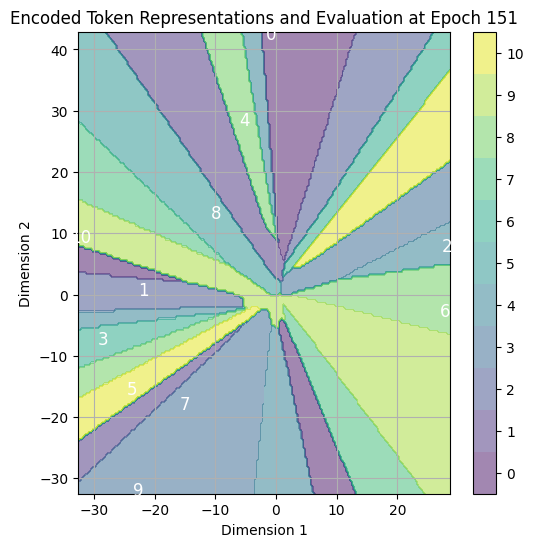

Epoch 500/50000, Train Loss: 0.0025, Test Loss: 106.2332, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 1000/50000, Train Loss: 0.0004, Test Loss: 127.1121, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 1500/50000, Train Loss: 0.0002, Test Loss: 137.8843, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 2000/50000, Train Loss: 0.0001, Test Loss: 145.4451, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 2500/50000, Train Loss: 0.0001, Test Loss: 151.4438, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 3000/50000, Train Loss: 0.0000, Test Loss: 156.4393, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 3500/50000, Train Loss: 0.0000, Test Loss: 160.8584, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 4000/50000, Train Loss: 0.0000, Test Loss: 165.3598, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 4500/50000, Train Loss: 0.0000, Test Loss: 169.5799, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 5000/50000, Train Loss: 0.0000, Test Loss: 173.4428, Train Acc: 1.0000, Test Acc: 0.1429


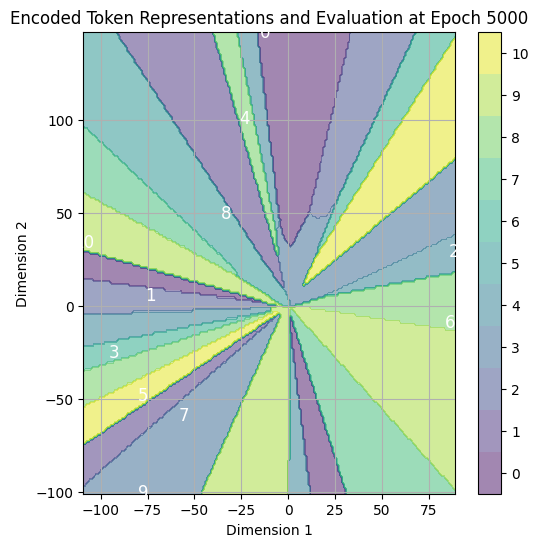

Epoch 5500/50000, Train Loss: 0.0000, Test Loss: 177.0384, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 6000/50000, Train Loss: 0.0000, Test Loss: 180.4345, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 6500/50000, Train Loss: 0.0000, Test Loss: 183.6517, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 7000/50000, Train Loss: 0.0000, Test Loss: 186.7528, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 7500/50000, Train Loss: 0.0000, Test Loss: 189.7258, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 8000/50000, Train Loss: 0.0000, Test Loss: 192.5365, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 8500/50000, Train Loss: 0.0000, Test Loss: 194.9343, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 9000/50000, Train Loss: 0.0000, Test Loss: 197.3175, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 9500/50000, Train Loss: 0.0000, Test Loss: 199.1796, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 10000/50000, Train Loss: 0.0000, Test Loss: 200.5288, Train Acc: 1.0000, Test Acc: 0.1429


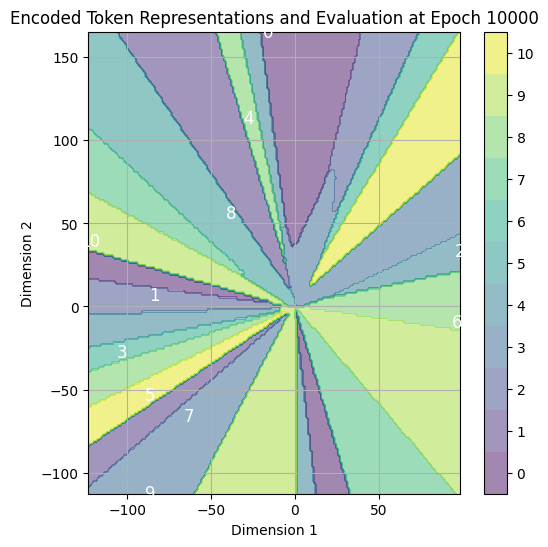

Epoch 10500/50000, Train Loss: 0.0000, Test Loss: 200.0313, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 11000/50000, Train Loss: 0.0000, Test Loss: 200.4051, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 11500/50000, Train Loss: 0.0000, Test Loss: 197.9732, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 12000/50000, Train Loss: 0.0000, Test Loss: 194.0861, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 12500/50000, Train Loss: 0.0000, Test Loss: 190.6200, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 13000/50000, Train Loss: 0.0000, Test Loss: 180.5126, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 13500/50000, Train Loss: 0.0000, Test Loss: 167.9667, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 14000/50000, Train Loss: 0.0000, Test Loss: 171.6410, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 14500/50000, Train Loss: 0.0000, Test Loss: 183.7965, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 15000/50000, Train Loss: 0.0000, Test Loss: 236.1566, Train Acc: 1.0000, Test Acc: 0.1429


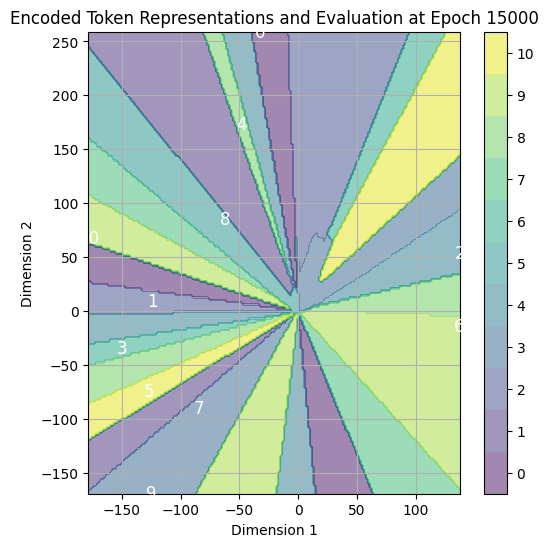

Epoch 15500/50000, Train Loss: 0.0000, Test Loss: 234.0338, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 16000/50000, Train Loss: 0.0000, Test Loss: 232.0064, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 16500/50000, Train Loss: 0.0000, Test Loss: 230.0085, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 17000/50000, Train Loss: 0.0000, Test Loss: 227.9773, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 17500/50000, Train Loss: 0.0000, Test Loss: 225.9163, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 18000/50000, Train Loss: 0.0000, Test Loss: 223.7471, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 18500/50000, Train Loss: 0.0000, Test Loss: 221.6916, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 19000/50000, Train Loss: 0.0000, Test Loss: 219.6562, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 19500/50000, Train Loss: 0.0000, Test Loss: 217.6413, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 20000/50000, Train Loss: 0.0000, Test Loss: 215.6540, Train Acc: 1.0000, Test Acc: 0.1429


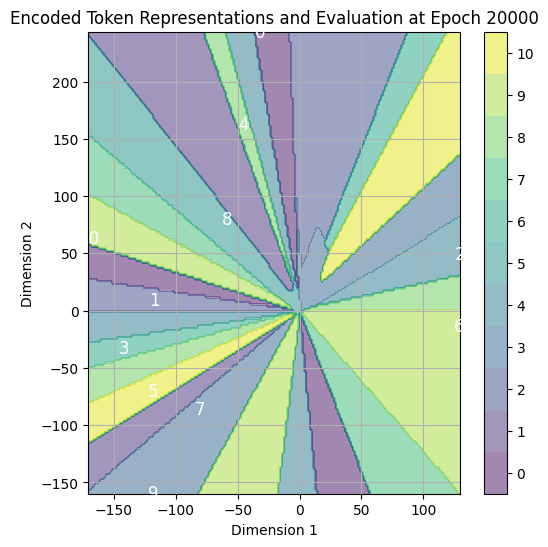

Epoch 20500/50000, Train Loss: 0.0000, Test Loss: 213.6843, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 21000/50000, Train Loss: 0.0000, Test Loss: 211.7291, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 21500/50000, Train Loss: 0.0000, Test Loss: 209.8035, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 22000/50000, Train Loss: 0.0000, Test Loss: 207.8807, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 22500/50000, Train Loss: 0.0000, Test Loss: 206.0330, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 23000/50000, Train Loss: 0.0000, Test Loss: 204.2062, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 23500/50000, Train Loss: 0.0000, Test Loss: 202.4752, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 24000/50000, Train Loss: 0.0000, Test Loss: 200.9743, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 24500/50000, Train Loss: 0.0000, Test Loss: 199.6115, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 25000/50000, Train Loss: 0.0000, Test Loss: 198.1806, Train Acc: 1.0000, Test Acc: 0.1429


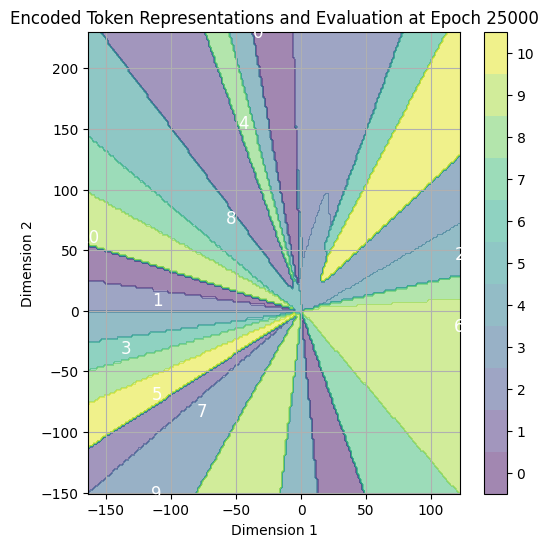

Epoch 25500/50000, Train Loss: 0.0000, Test Loss: 196.8759, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 26000/50000, Train Loss: 0.0000, Test Loss: 195.7885, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 26500/50000, Train Loss: 0.0000, Test Loss: 194.5170, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 27000/50000, Train Loss: 0.0000, Test Loss: 193.1421, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 27500/50000, Train Loss: 0.0000, Test Loss: 192.1823, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 28000/50000, Train Loss: 0.0000, Test Loss: 191.5357, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 28500/50000, Train Loss: 0.0000, Test Loss: 191.0657, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 29000/50000, Train Loss: 0.0000, Test Loss: 190.6286, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 29500/50000, Train Loss: 0.0000, Test Loss: 190.2048, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 30000/50000, Train Loss: 0.0000, Test Loss: 189.8598, Train Acc: 1.0000, Test Acc: 0.1429


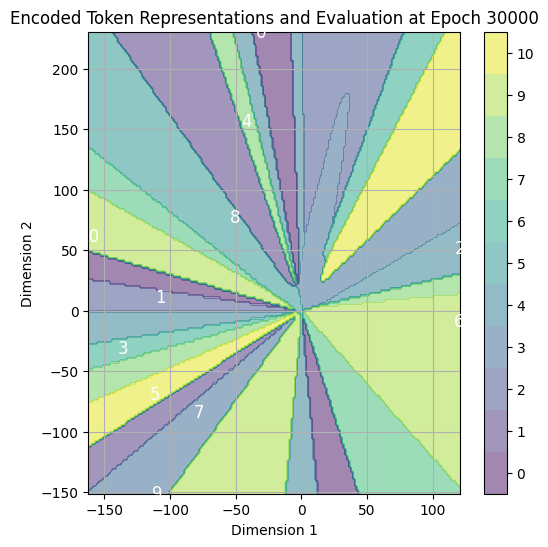

Epoch 30500/50000, Train Loss: 0.0000, Test Loss: 191.0905, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 31000/50000, Train Loss: 0.0000, Test Loss: 191.9619, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 31500/50000, Train Loss: 0.0000, Test Loss: 197.4708, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 32000/50000, Train Loss: 0.0000, Test Loss: 208.1779, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 32500/50000, Train Loss: 0.0000, Test Loss: 217.7281, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 33000/50000, Train Loss: 0.0000, Test Loss: 233.3339, Train Acc: 1.0000, Test Acc: 0.0714
Epoch 33500/50000, Train Loss: 0.0000, Test Loss: 258.7449, Train Acc: 1.0000, Test Acc: 0.0714
Epoch 34000/50000, Train Loss: 0.0000, Test Loss: 296.3173, Train Acc: 1.0000, Test Acc: 0.0714
Epoch 34500/50000, Train Loss: 0.0000, Test Loss: 374.7145, Train Acc: 1.0000, Test Acc: 0.0714
Epoch 35000/50000, Train Loss: 0.0000, Test Loss: 434.3704, Train Acc: 1.0000, Test Acc: 0.1429


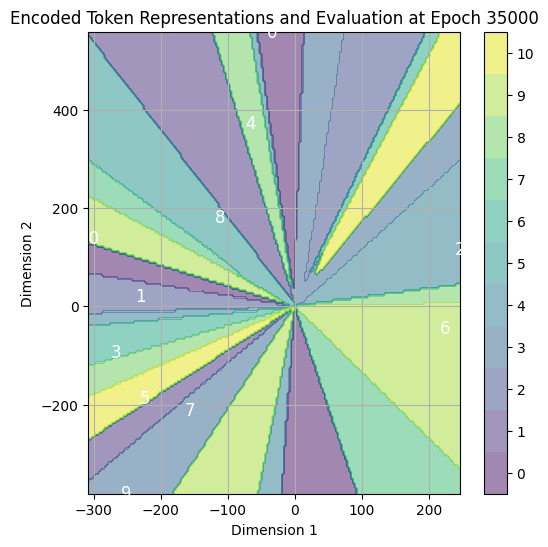

Epoch 35500/50000, Train Loss: 0.0000, Test Loss: 429.9149, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 36000/50000, Train Loss: 0.0000, Test Loss: 425.4711, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 36500/50000, Train Loss: 0.0000, Test Loss: 421.0644, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 37000/50000, Train Loss: 0.0000, Test Loss: 416.6932, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 37500/50000, Train Loss: 0.0000, Test Loss: 412.3539, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 38000/50000, Train Loss: 0.0000, Test Loss: 408.0410, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 38500/50000, Train Loss: 0.0000, Test Loss: 403.7651, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 39000/50000, Train Loss: 0.0000, Test Loss: 399.5530, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 39500/50000, Train Loss: 0.0000, Test Loss: 395.3855, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 40000/50000, Train Loss: 0.0000, Test Loss: 391.2647, Train Acc: 1.0000, Test Acc: 0.1429


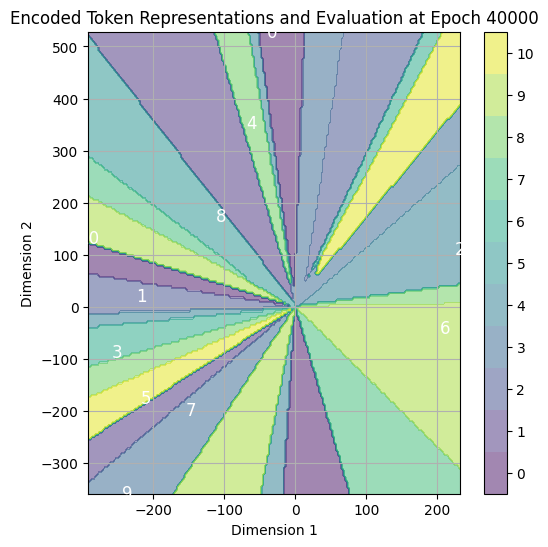

Epoch 40500/50000, Train Loss: 0.0000, Test Loss: 387.1799, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 41000/50000, Train Loss: 0.0000, Test Loss: 383.1186, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 41500/50000, Train Loss: 0.0000, Test Loss: 379.0883, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 42000/50000, Train Loss: 0.0000, Test Loss: 375.0332, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 42500/50000, Train Loss: 0.0000, Test Loss: 371.1063, Train Acc: 1.0000, Test Acc: 0.2143
Epoch 43000/50000, Train Loss: 0.0000, Test Loss: 367.1223, Train Acc: 1.0000, Test Acc: 0.2143
Epoch 43500/50000, Train Loss: 0.0000, Test Loss: 363.3156, Train Acc: 1.0000, Test Acc: 0.2143
Epoch 44000/50000, Train Loss: 0.0000, Test Loss: 359.5572, Train Acc: 1.0000, Test Acc: 0.2143
Epoch 44500/50000, Train Loss: 0.0000, Test Loss: 355.7572, Train Acc: 1.0000, Test Acc: 0.2143
Epoch 45000/50000, Train Loss: 0.0000, Test Loss: 352.2852, Train Acc: 1.0000, Test Acc: 0.2143


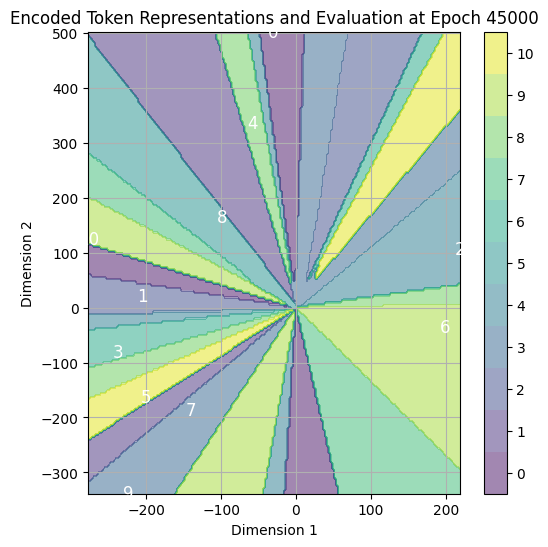

Epoch 45500/50000, Train Loss: 0.0000, Test Loss: 348.8516, Train Acc: 1.0000, Test Acc: 0.2143
Epoch 46000/50000, Train Loss: 0.0000, Test Loss: 345.3055, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 46500/50000, Train Loss: 0.0000, Test Loss: 341.8580, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 47000/50000, Train Loss: 0.0000, Test Loss: 341.5304, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 47500/50000, Train Loss: 0.0000, Test Loss: 342.2990, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 48000/50000, Train Loss: 0.0000, Test Loss: 341.3526, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 48500/50000, Train Loss: 0.0000, Test Loss: 340.6258, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 49000/50000, Train Loss: 0.0000, Test Loss: 337.7955, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 49500/50000, Train Loss: 0.0000, Test Loss: 335.8351, Train Acc: 1.0000, Test Acc: 0.1429
Epoch 50000/50000, Train Loss: 0.0000, Test Loss: 333.8236, Train Acc: 1.0000, Test Acc: 0.1429


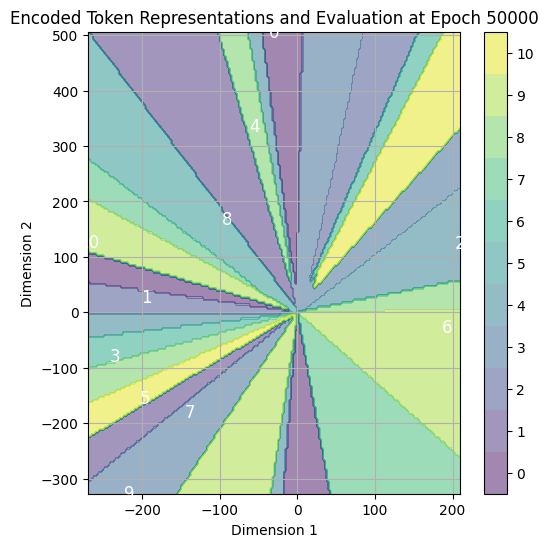

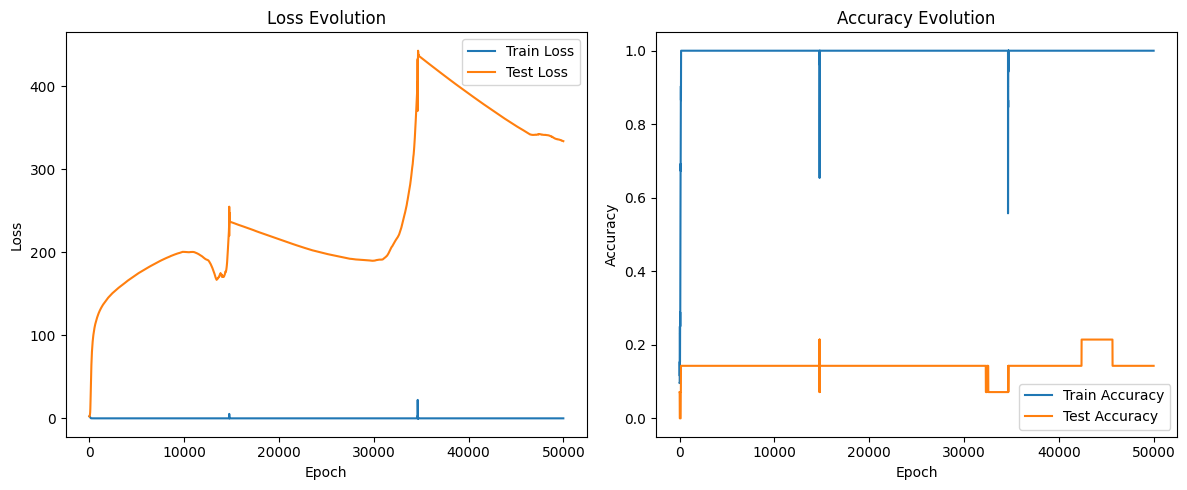

In [342]:
easy_p3 = 11
easy_model3 = TokenMLP(easy_p3, embedding_dim=48, encoder_dim=2, hidden_dim=200, encoder_depth=3, decoder_depth=3) # vocab_size, embedding_dim, encoder_dim, hidden_dim, encoder_depth, decoder_depth
trained_easy_model3 = train_easy_model2(easy_model3, easy_p3, proportion=0.8, num_epochs=50000)

### Toy Model

In [346]:
def train_toy_model(model, p, proportion, num_epochs): #it adds the values of the colors
    """
    Trains a TokenMLP model for modular addition.

    Args:
        model: The TokenMLP model to train.
        p (int): The prime number used in modular addition.
        proportion (float): Proportion of the dataset to use for training (between 0 and 1).
        num_epochs (int): Number of training epochs.
    
    Returns:
        model: The trained model.
    """
    # Generate the full dataset.
    inputs, labels = generate_easy_modular_addition_data(p)
    total_examples = inputs.shape[0]
    
    # Split the dataset into training and test sets.
    train_size = int(proportion * total_examples)
    indices = torch.randperm(total_examples)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    train_inputs = inputs[train_indices]
    train_labels = labels[train_indices]
    test_inputs = inputs[test_indices]
    test_labels = labels[test_indices]

    # Define the optimizer and loss function.
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01, betas=(0.9, 0.999))
    # Model now returns raw logits, so we directly use CrossEntropyLoss.
    criterion = nn.CrossEntropyLoss()

    # Lists for storing metrics.
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    count_train1 = 0
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Forward pass on the training set.
        logits = model(train_inputs)  # shape: (train_size, vocab_size)
        loss = criterion(logits, train_labels)
        loss.backward()
        optimizer.step()

        # Compute training metrics.
        train_loss = loss.item()
        _, train_preds = torch.max(torch.softmax(logits, dim=1), dim=1)
        train_accuracy = (train_preds == train_labels).float().mean().item()

        if train_accuracy == 1:
            count_train1 += 1


        # Evaluate on the test set.
        model.eval()
        with torch.no_grad():
            test_logits = model(test_inputs)
            test_loss = criterion(test_logits, test_labels).item()
            _, test_preds = torch.max(torch.softmax(test_logits, dim=1), dim=1)
            test_accuracy = (test_preds == test_labels).float().mean().item()
        model.train()

        # Record metrics.
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print metrics every 500 epochs.
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")
        
        if count_train1 == 1:
            with torch.no_grad():
                # Instead of using model.embedding.weight directly, we use model.fixed_embedding.
                token_emb = model.fixed_embedding  # shape: (vocab_size, embedding_dim)
                encoded = model.encoder(token_emb)    # shape: (vocab_size, encoder_dim)
            encoded_np = encoded.detach().cpu().numpy()
            num_tokens = encoded_np.shape[0]

            # Create token labels (tokens 0 to num_tokens-1)
            token_labels = [str(i) for i in range(num_tokens)]

            plt.figure(figsize=(6, 6))

            # Determine grid boundaries based on the encoded representations.
            margin = 0.5
            x_min, x_max = encoded_np[:, 0].min() - margin, encoded_np[:, 0].max() + margin
            y_min, y_max = encoded_np[:, 1].min() - margin, encoded_np[:, 1].max() + margin

            # Create a grid of points in the encoder space (assumed to be 2D).
            grid_resolution = 200
            x_vals = np.linspace(x_min, x_max, grid_resolution)
            y_vals = np.linspace(y_min, y_max, grid_resolution)
            xx, yy = np.meshgrid(x_vals, y_vals)
            grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # shape: (grid_resolution^2, 2)

            # Evaluate the function that maps from the encoder space to the logits/probabilities.
            grid_tensor = torch.tensor(grid, dtype=torch.float, device=encoded.device)
            with torch.no_grad():
                # Pass grid points through the decoder to get logits.
                logits_grid = model.decoder(grid_tensor)        # shape: (N, vocab_size)
                probs_grid = torch.softmax(logits_grid, dim=1)     # shape: (N, vocab_size)
                preds = torch.argmax(probs_grid, dim=1)         
            preds_np = preds.cpu().numpy().reshape(xx.shape)

            # Create discrete levels for the colormap.
            levels = np.linspace(-0.5, num_tokens - 0.5, num_tokens + 1)

            # Plot the decision regions with these levels.
            contour = plt.contourf(xx, yy, preds_np, levels=levels, alpha=0.5, cmap="viridis")

            # Add a colorbar with ticks placed at each integer value.
            cbar = plt.colorbar(contour, ticks=np.arange(num_tokens))
            cbar.ax.set_yticklabels(token_labels)

            # Overlay the token labels at their encoded positions.
            for i, enc in enumerate(encoded_np):
                x = enc[0]
                y = enc[1] if enc.shape[0] >= 2 else 0
                plt.text(x, y, token_labels[i], fontsize=12, ha='center', va='center', color='white')

            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.title(f"Encoded Token Representations and Evaluation at Epoch {epoch+1}")
            plt.grid(True)
            plt.show()


            
        # Every 5000 epochs, plot the encoded token representations and decision boundaries.
        if (epoch + 1) % 5000 == 0:
            with torch.no_grad():
                # Instead of using model.embedding.weight directly, we use model.fixed_embedding.
                token_emb = model.fixed_embedding  # shape: (vocab_size, embedding_dim)
                encoded = model.encoder(token_emb)    # shape: (vocab_size, encoder_dim)
            encoded_np = encoded.detach().cpu().numpy()
            num_tokens = encoded_np.shape[0]

            # Create token labels (tokens 0 to num_tokens-1)
            token_labels = [str(i) for i in range(num_tokens)]

            plt.figure(figsize=(6, 6))

            # Determine grid boundaries based on the encoded representations.
            margin = 0.5
            x_min, x_max = encoded_np[:, 0].min() - margin, encoded_np[:, 0].max() + margin
            y_min, y_max = encoded_np[:, 1].min() - margin, encoded_np[:, 1].max() + margin

            # Create a grid of points in the encoder space (assumed to be 2D).
            grid_resolution = 200
            x_vals = np.linspace(x_min, x_max, grid_resolution)
            y_vals = np.linspace(y_min, y_max, grid_resolution)
            xx, yy = np.meshgrid(x_vals, y_vals)
            grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # shape: (grid_resolution^2, 2)

            # Evaluate the function that maps from the encoder space to the logits/probabilities.
            grid_tensor = torch.tensor(grid, dtype=torch.float, device=encoded.device)
            with torch.no_grad():
                # Pass grid points through the decoder to get logits.
                logits_grid = model.decoder(grid_tensor)        # shape: (N, vocab_size)
                probs_grid = torch.softmax(logits_grid, dim=1)     # shape: (N, vocab_size)
                preds = torch.argmax(probs_grid, dim=1)         
            preds_np = preds.cpu().numpy().reshape(xx.shape)

            # Create discrete levels for the colormap.
            levels = np.linspace(-0.5, num_tokens - 0.5, num_tokens + 1)

            # Plot the decision regions with these levels.
            contour = plt.contourf(xx, yy, preds_np, levels=levels, alpha=0.5, cmap="viridis")

            # Add a colorbar with ticks placed at each integer value.
            cbar = plt.colorbar(contour, ticks=np.arange(num_tokens))
            cbar.ax.set_yticklabels(token_labels)

            # Overlay the token labels at their encoded positions.
            for i, enc in enumerate(encoded_np):
                x = enc[0]
                y = enc[1] if enc.shape[0] >= 2 else 0
                plt.text(x, y, token_labels[i], fontsize=12, ha='center', va='center', color='white')

            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.title(f"Encoded Token Representations and Evaluation at Epoch {epoch+1}")
            plt.grid(True)
            plt.show()
         
    # Plot the evolution of loss and accuracy.
    epochs_range = range(1, num_epochs + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Loss evolution.
    axs[0].plot(epochs_range, train_losses, label="Train Loss")
    axs[0].plot(epochs_range, test_losses, label="Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss Evolution")
    axs[0].legend()

    # Accuracy evolution.
    axs[1].plot(epochs_range, train_accuracies, label="Train Accuracy")
    axs[1].plot(epochs_range, test_accuracies, label="Test Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy Evolution")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return model


In [347]:
class ToyModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, encoder_dim, hidden_dim, encoder_depth, decoder_depth):
        """
        Args:
            vocab_size (int): Number of tokens.
            embedding_dim (int): Dimension of the token embeddings.
            encoder_dim (int): Dimension of the encoded representation.
            hidden_dim (int): Internal hidden dimension used in the MLP layers.
            encoder_depth (int): Number of layers in the encoder.
            decoder_depth (int): Number of layers in the decoder.
        """
        super(ToyModel, self).__init__()
        # Create fixed embeddings: sample points from a standard normal distribution.
        fixed_embedding = torch.randn(vocab_size, embedding_dim)
        # Normalize each token's embedding vector to have unit norm.
        fixed_embedding = fixed_embedding / fixed_embedding.norm(dim=1, keepdim=True)
        # Register the fixed embedding as a buffer so it won't be updated during training.
        self.register_buffer('fixed_embedding', fixed_embedding)
        
        # ----- Build the Encoder -----
        if encoder_depth < 1:
            raise ValueError("encoder_depth must be >= 1")
        encoder_layers = []
        if encoder_depth == 1:
            encoder_layers.append(nn.Linear(embedding_dim, encoder_dim))
        else:
            # First layer: embedding_dim -> hidden_dim
            encoder_layers.append(nn.Linear(embedding_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            # Intermediate layers (if any)
            for _ in range(encoder_depth - 2):
                encoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
                encoder_layers.append(nn.ReLU())
            # Final layer: hidden_dim -> encoder_dim
            encoder_layers.append(nn.Linear(hidden_dim, encoder_dim))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # ----- Build the Decoder -----
        if decoder_depth < 1:
            raise ValueError("decoder_depth must be >= 1")
        decoder_layers = []
        if decoder_depth == 1:
            decoder_layers.append(nn.Linear(encoder_dim, vocab_size))
        else:
            # First decoder layer: encoder_dim -> hidden_dim
            decoder_layers.append(nn.Linear(encoder_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())
            # Intermediate layers (if any)
            for _ in range(decoder_depth - 2):
                decoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
                decoder_layers.append(nn.ReLU())
            # Final decoder layer: hidden_dim -> vocab_size
            decoder_layers.append(nn.Linear(hidden_dim, vocab_size))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        """
        x: LongTensor of shape (batch_size, sequence_length)
        
        The tokens are first embedded using the fixed, non-learnable embedding,
        then each token's embedding is processed through the encoder.
        The encoded representations are aggregated (summed and divided by 2)
        and finally passed through the decoder.
        """
        # Retrieve embeddings by indexing into the fixed embedding buffer.
        # Resulting shape: (batch_size, sequence_length, embedding_dim)
        embedded = self.fixed_embedding[x]
        
        bs, seq, _ = embedded.shape
        # Process tokens: flatten batch and sequence dimensions for the encoder.
        encoded_tokens = self.encoder(embedded.view(-1, embedded.shape[-1]))
        # Reshape back to (batch_size, sequence_length, encoder_dim)
        encoded_tokens = encoded_tokens.view(bs, seq, -1)
        
        # Aggregate encoded tokens (division by 2 is as specified).
        aggregated = encoded_tokens.sum(dim=1) / 2
        # Decode aggregated encoding to logits over tokens.
        logits = self.decoder(aggregated)
        return logits

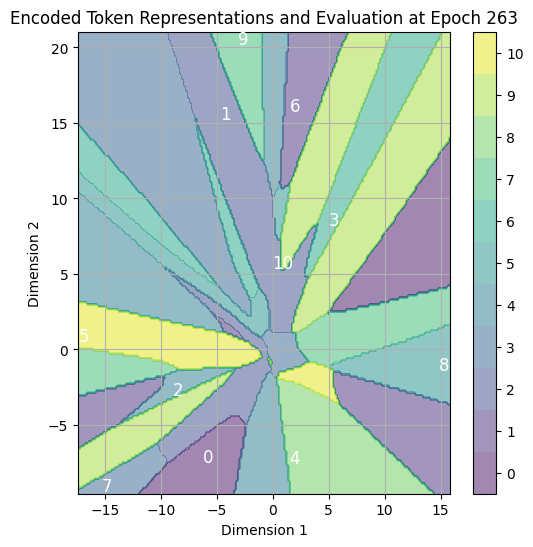

Epoch 500/50000, Train Loss: 0.0189, Test Loss: 83.8932, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 1000/50000, Train Loss: 0.0022, Test Loss: 115.1257, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 1500/50000, Train Loss: 0.0008, Test Loss: 129.6358, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 2000/50000, Train Loss: 0.0004, Test Loss: 139.4919, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 2500/50000, Train Loss: 0.0002, Test Loss: 147.2022, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 3000/50000, Train Loss: 0.0001, Test Loss: 153.6222, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 3500/50000, Train Loss: 0.0001, Test Loss: 159.3094, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 4000/50000, Train Loss: 0.0001, Test Loss: 165.0081, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 4500/50000, Train Loss: 0.0000, Test Loss: 170.1133, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 5000/50000, Train Loss: 0.0000, Test Loss: 174.8603, Train Acc: 1.0000, Test Acc: 0.0000


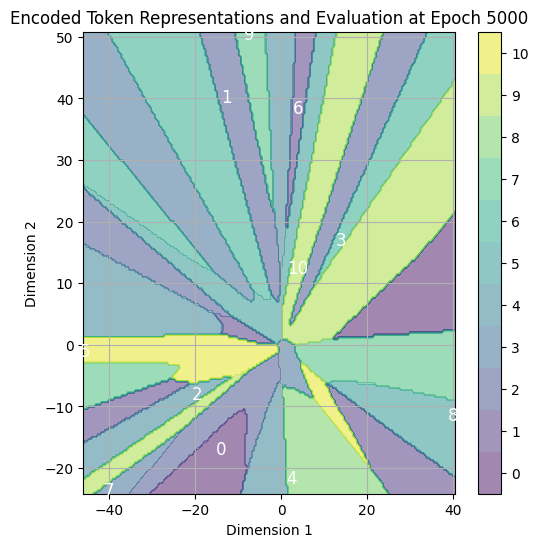

Epoch 5500/50000, Train Loss: 0.0000, Test Loss: 179.3190, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 6000/50000, Train Loss: 0.0000, Test Loss: 183.5327, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 6500/50000, Train Loss: 0.0000, Test Loss: 187.5021, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 7000/50000, Train Loss: 0.0000, Test Loss: 191.3599, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 7500/50000, Train Loss: 0.0000, Test Loss: 195.1541, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 8000/50000, Train Loss: 0.0000, Test Loss: 198.9141, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 8500/50000, Train Loss: 0.0000, Test Loss: 202.4192, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 9000/50000, Train Loss: 0.0000, Test Loss: 205.7202, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 9500/50000, Train Loss: 0.0000, Test Loss: 209.0566, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 10000/50000, Train Loss: 0.0000, Test Loss: 212.1637, Train Acc: 1.0000, Test Acc: 0.0000


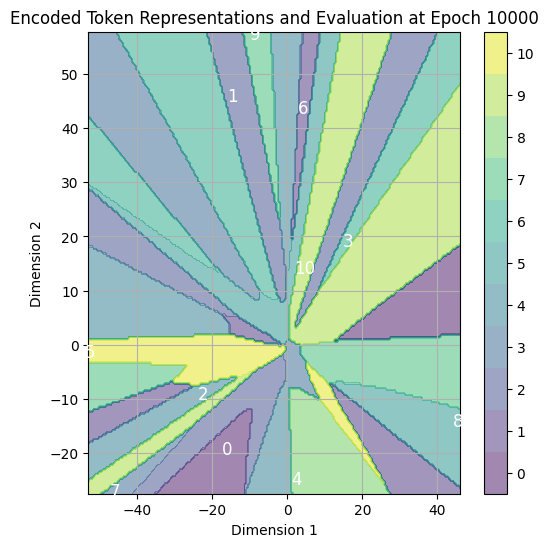

Epoch 10500/50000, Train Loss: 0.0000, Test Loss: 215.4765, Train Acc: 1.0000, Test Acc: 0.0000
Epoch 11000/50000, Train Loss: 0.0000, Test Loss: 218.3944, Train Acc: 1.0000, Test Acc: 0.0000


KeyboardInterrupt: 

In [348]:
toy_p = 11
toy_model = ToyModel(toy_p, embedding_dim=16, encoder_dim=2, hidden_dim=200, encoder_depth=3, decoder_depth=3) # vocab_size, embedding_dim, encoder_dim, hidden_dim, encoder_depth, decoder_depth
trained_toy_model = train_toy_model(toy_model, toy_p, proportion=0.75, num_epochs=50000)